# Neural Networks for Bitcoin Predictions Buy/Sell

# Setup

In [1]:


#tensorflow
import tensorflow as tf
from tensorflow import keras

#sklearn
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Common imports
import numpy as np
import pandas as pd
import os
import os.path
import urllib

# To plot pretty figures
import matplotlib.pyplot as plt

In [2]:
def plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin), max(ymax))
    plt.xlabel("EPOCHS")
    plt.show()

In [3]:
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
def plot_forecast(Y, Y_pred, Y_actual=None):
    n_steps = Y.shape[0]
    ahead = Y_pred.shape[0]
    plt.plot(Y,"b-", alpha=.6)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred, "rx-", label="Forecast")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_actual, "b.-", label="Actual")
    plt.legend()
    plt.grid()

In [5]:
#define a metric that provides the MSE on the last step only (the real test for this squential learning that is happening)
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
!pip install requests_html
!pip install yahoo_fin

## Source Data

In [6]:

import datetime
import yfinance
import pandas_ta #noqa
TICKER = 'BTC-USD' # TODO: replace this with your own ticker
TRAIN_START_DATE = '2020-12-25' # TODO: replace this with your own start date


TRAIN_END_DATE = '2021-12-23'

yf_ticker = yfinance.Ticker(ticker=TICKER)


df_training = yf_ticker.history(start=TRAIN_START_DATE, end=TRAIN_END_DATE, interval='60m')
df_training.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
df_training["Volume"] = df_training["Volume"].astype(int)
df_training.ta.log_return(append=True, length=16)
df_training.ta.rsi(append=True, length=14)
df_training.ta.macd(append=True, fast=12, slow=26)
df_training['Date']=df_training.index.date

df_training.to_csv('C:/Users/Mary Jane/Downloads/BTC_{}.csv'.format(TRAIN_END_DATE), index=True)
df_training



,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date
Datetime,,,,,,,,,,,
2020-12-25 05:00:00+00:00,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 06:00:00+00:00,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 07:00:00+00:00,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 08:00:00+00:00,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 09:00:00+00:00,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,2020-12-25
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23 00:00:00+00:00,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,2021-12-23
2021-12-23 01:00:00+00:00,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,2021-12-23
2021-12-23 02:00:00+00:00,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,2021-12-23


In [7]:
!pip install pandas_datareader
!pip install mplfinance



In [8]:
import pandas_datareader as pdr
import datetime
import time

start = datetime.datetime(2020, 12, 25)
end = datetime.datetime(2021, 12, 23)
syms = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS3', 'DGS10']
df = pd.DataFrame()
for sym in syms:
    ts = pdr.fred.FredReader(sym, start=start, end=end)
    df1 = ts.read()
    df = pd.concat([df, df1], axis=1)
df

,DGS1MO,DGS3MO,DGS1,DGS3,DGS10
DATE,,,,,
2020-12-25,NaN,NaN,NaN,NaN,NaN
2020-12-28,0.09,0.11,0.11,0.17,0.94
2020-12-29,0.08,0.10,0.11,0.17,0.94
2020-12-30,0.06,0.08,0.12,0.17,0.93
2020-12-31,0.08,0.09,0.10,0.17,0.93
...,...,...,...,...,...
2021-12-16,0.04,0.05,0.26,0.92,1.44
2021-12-17,0.03,0.05,0.27,0.93,1.41
2021-12-20,0.03,0.07,0.27,0.91,1.43


In [9]:
InterestRates= df

In [10]:
InterestRates

,DGS1MO,DGS3MO,DGS1,DGS3,DGS10
DATE,,,,,
2020-12-25,NaN,NaN,NaN,NaN,NaN
2020-12-28,0.09,0.11,0.11,0.17,0.94
2020-12-29,0.08,0.10,0.11,0.17,0.94
2020-12-30,0.06,0.08,0.12,0.17,0.93
2020-12-31,0.08,0.09,0.10,0.17,0.93
...,...,...,...,...,...
2021-12-16,0.04,0.05,0.26,0.92,1.44
2021-12-17,0.03,0.05,0.27,0.93,1.41
2021-12-20,0.03,0.07,0.27,0.91,1.43


In [11]:
#add weekend dates for economic market metrics merge (the economic market metrics are only provided on a weekday/trading day
#basis)

import pandas as pd

idx = pd.date_range('12-25-2020', '12-23-2021')




InterestRates = InterestRates.reindex(idx, fill_value=np.nan)
InterestRates

,DGS1MO,DGS3MO,DGS1,DGS3,DGS10
2020-12-25,NaN,NaN,NaN,NaN,NaN
2020-12-26,NaN,NaN,NaN,NaN,NaN
2020-12-27,NaN,NaN,NaN,NaN,NaN
2020-12-28,0.09,0.11,0.11,0.17,0.94
2020-12-29,0.08,0.10,0.11,0.17,0.94
...,...,...,...,...,...
2021-12-19,NaN,NaN,NaN,NaN,NaN
2021-12-20,0.03,0.07,0.27,0.91,1.43
2021-12-21,0.03,0.07,0.29,0.96,1.48
2021-12-22,0.03,0.08,0.28,0.96,1.46


In [12]:
InterestRates['Date']=InterestRates.index.date

In [13]:
#!pip install mplfinance

In [14]:
import pandas as pd
import pandas_datareader as pdr
import mplfinance as mpf
ts = pdr.av.time_series.AVTimeSeriesReader('RINF', api_key='A0FRPV75ZBATMOHH')
df = ts.read()
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df

,open,high,low,close,volume
2012-01-12,39.6561,40.4500,38.840,39.2600,10100
2012-01-13,39.7600,40.8100,39.390,39.5800,5200
2012-01-17,39.4600,39.4600,38.120,39.2600,4900
2012-01-18,39.5100,40.6700,38.610,38.6500,24500
2012-01-19,39.7300,40.7600,39.720,40.2100,1200
...,...,...,...,...,...
2021-12-17,29.6400,29.6400,29.485,29.4940,33006
2021-12-20,29.4400,29.7300,29.390,29.7300,28534
2021-12-21,29.8700,30.2600,29.870,30.2600,8436
2021-12-22,30.1700,30.3950,30.170,30.3450,6348


In [15]:
CPI = df

In [16]:
CPI

,open,high,low,close,volume
2012-01-12,39.6561,40.4500,38.840,39.2600,10100
2012-01-13,39.7600,40.8100,39.390,39.5800,5200
2012-01-17,39.4600,39.4600,38.120,39.2600,4900
2012-01-18,39.5100,40.6700,38.610,38.6500,24500
2012-01-19,39.7300,40.7600,39.720,40.2100,1200
...,...,...,...,...,...
2021-12-17,29.6400,29.6400,29.485,29.4940,33006
2021-12-20,29.4400,29.7300,29.390,29.7300,28534
2021-12-21,29.8700,30.2600,29.870,30.2600,8436
2021-12-22,30.1700,30.3950,30.170,30.3450,6348


In [17]:
CPI.columns = ['CPIopen','CPIhigh','CPIlow','CPIclose','CPIvolume']

In [18]:
CPI

,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume
2012-01-12,39.6561,40.4500,38.840,39.2600,10100
2012-01-13,39.7600,40.8100,39.390,39.5800,5200
2012-01-17,39.4600,39.4600,38.120,39.2600,4900
2012-01-18,39.5100,40.6700,38.610,38.6500,24500
2012-01-19,39.7300,40.7600,39.720,40.2100,1200
...,...,...,...,...,...
2021-12-17,29.6400,29.6400,29.485,29.4940,33006
2021-12-20,29.4400,29.7300,29.390,29.7300,28534
2021-12-21,29.8700,30.2600,29.870,30.2600,8436
2021-12-22,30.1700,30.3950,30.170,30.3450,6348


In [19]:
CPI['CPIChange_Close']=CPI.CPIclose.pct_change()
CPI['CPIChange_Open']=CPI.CPIopen.pct_change()
CPI['CPIChange_high']=CPI.CPIhigh.pct_change()
CPI['CPIChange_low']=CPI.CPIlow.pct_change()

In [20]:
import pandas as pd

#add weekend dates for economic market metrics merge (the economic market metrics are only provided on a weekday/trading day
#basis)

idx = pd.date_range('01-12-2012', '12-23-2021')




CPI = CPI.reindex(idx, fill_value=np.nan)
CPI

,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low
2012-01-12,39.6561,40.4500,38.84,39.2600,10100.0,NaN,NaN,NaN,NaN
2012-01-13,39.7600,40.8100,39.39,39.5800,5200.0,0.008151,0.002620,0.008900,0.014161
2012-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-20,29.4400,29.7300,29.39,29.7300,28534.0,0.008002,-0.006748,0.003036,-0.003222
2021-12-21,29.8700,30.2600,29.87,30.2600,8436.0,0.017827,0.014606,0.017827,0.016332
2021-12-22,30.1700,30.3950,30.17,30.3450,6348.0,0.002809,0.010044,0.004461,0.010044


In [21]:
CPI['Date']=CPI.index.date

In [22]:
CPI['Date'] = pd.to_datetime(CPI['Date'])

In [23]:
CPI

,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low,Date
2012-01-12,39.6561,40.4500,38.84,39.2600,10100.0,NaN,NaN,NaN,NaN,2012-01-12
2012-01-13,39.7600,40.8100,39.39,39.5800,5200.0,0.008151,0.002620,0.008900,0.014161,2012-01-13
2012-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-14
2012-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-15
2012-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-16
...,...,...,...,...,...,...,...,...,...,...
2021-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-19
2021-12-20,29.4400,29.7300,29.39,29.7300,28534.0,0.008002,-0.006748,0.003036,-0.003222,2021-12-20
2021-12-21,29.8700,30.2600,29.87,30.2600,8436.0,0.017827,0.014606,0.017827,0.016332,2021-12-21
2021-12-22,30.1700,30.3950,30.17,30.3450,6348.0,0.002809,0.010044,0.004461,0.010044,2021-12-22


In [24]:

df_training

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date
Datetime,,,,,,,,,,,
2020-12-25 05:00:00+00:00,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 06:00:00+00:00,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 07:00:00+00:00,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 08:00:00+00:00,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,2020-12-25
2020-12-25 09:00:00+00:00,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,2020-12-25
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23 00:00:00+00:00,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,2021-12-23
2021-12-23 01:00:00+00:00,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,2021-12-23
2021-12-23 02:00:00+00:00,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,2021-12-23


In [25]:
#Create a weekday label 

df_training['WEEKDAY'] = ((pd.DatetimeIndex(df_training.Date).dayofweek) // 5 == 1).astype(float)

In [26]:
df_training['Date'] = pd.to_datetime(df_training['Date'])
InterestRates['Date'] = pd.to_datetime(InterestRates['Date'])

In [27]:
data=df_training.merge(InterestRates, how='inner', left_on='Date', right_on='Date')
data

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date,WEEKDAY,DGS1MO,DGS3MO,DGS1,DGS3,DGS10
0,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,2020-12-25,0.0,NaN,NaN,NaN,NaN,NaN
1,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,2020-12-25,0.0,NaN,NaN,NaN,NaN,NaN
2,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,2020-12-25,0.0,NaN,NaN,NaN,NaN,NaN
3,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,2020-12-25,0.0,NaN,NaN,NaN,NaN,NaN
4,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,2020-12-25,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,2021-12-23,0.0,NaN,NaN,NaN,NaN,NaN
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,2021-12-23,0.0,NaN,NaN,NaN,NaN,NaN
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,2021-12-23,0.0,NaN,NaN,NaN,NaN,NaN
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,2021-12-23,0.0,NaN,NaN,NaN,NaN,NaN


In [28]:
data=data.merge(CPI, how='inner', left_on='Date', right_on='Date')
data

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DGS10,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low
0,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,NaN,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,NaN,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,NaN,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,NaN,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657


In [29]:
data.head(50)

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DGS10,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low
0,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,23952.195312,23993.802734,23879.076172,23970.882812,746717184,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23972.416016,24585.240234,23935.679688,24578.238281,-1394151424,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,24559.458984,24596.339844,24427.667969,24427.667969,430977024,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,24424.226562,24478.322266,24364.494141,24476.423828,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,24474.537109,24498.027344,24040.808594,24079.685547,857755648,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#merged data left weekend dates (rows) with NA 'ffill' backfills the data to the previous Friday/trading day

data.DGS1MO=data.DGS1MO.fillna(method='ffill')
data.DGS3MO=data.DGS3MO.fillna(method='ffill')
data.DGS1=data.DGS1.fillna(method='ffill')
data.DGS3=data.DGS3.fillna(method='ffill')
data.DGS10=data.DGS10.fillna(method='ffill')
data


,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DGS10,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low
0,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657


In [31]:
data.CPIopen=data.CPIopen.fillna(method='ffill')
data.CPIhigh=data.CPIhigh.fillna(method='ffill')
data.CPIlow=data.CPIlow.fillna(method='ffill')
data.CPIclose=data.CPIclose.fillna(method='ffill')
data.CPIvolume=data.CPIvolume.fillna(method='ffill')
data.CPIChange_Close=data.CPIChange_Close.fillna(method='ffill')
data.CPIChange_Open=data.CPIChange_Open.fillna(method='ffill')
data.CPIChange_high=data.CPIChange_high.fillna(method='ffill')
data.CPIChange_low=data.CPIChange_low.fillna(method='ffill')
data

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DGS10,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low
0,23587.919922,23637.640625,23551.984375,23581.488281,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23580.441406,23671.927734,23570.427734,23645.935547,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23645.025391,23671.974609,23546.740234,23669.400391,14934016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23670.427734,23846.271484,23663.570312,23692.476562,546476032,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23691.421875,23955.707031,23684.156250,23951.150391,526426112,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,1.46,30.13,30.1999,30.12,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657


In [32]:
data=data.dropna()

In [33]:
data

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DGS10,CPIopen,CPIhigh,CPIlow,CPIclose,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low
64,26280.822266,26936.009766,26207.640625,26873.121094,1828372480,-0.030897,53.849639,113.910717,-163.673081,277.583797,...,0.94,27.155,27.2099,27.155,27.1600,1039.0,0.001678,0.003882,-0.000371,0.003882
65,26870.443359,27284.755859,26842.302734,27005.541016,502681600,-0.027331,55.725077,124.821465,-122.209866,247.031331,...,0.94,27.155,27.2099,27.155,27.1600,1039.0,0.001678,0.003882,-0.000371,0.003882
66,27010.570312,27120.554688,26952.712891,27081.837891,0,-0.025278,56.814028,138.033666,-87.198132,225.231798,...,0.94,27.155,27.2099,27.155,27.1600,1039.0,0.001678,0.003882,-0.000371,0.003882
67,27073.875000,27196.306641,26938.458984,27168.214844,0,-0.014581,58.071325,153.702542,-57.223405,210.925947,...,0.94,27.155,27.2099,27.155,27.1600,1039.0,0.001678,0.003882,-0.000371,0.003882
68,27170.271484,27246.910156,26938.601562,26991.490234,49496064,-0.010588,54.570755,150.129441,-48.637205,198.766646,...,0.94,27.155,27.2099,27.155,27.1600,1039.0,0.001678,0.003882,-0.000371,0.003882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,1.46,30.130,30.1999,30.120,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,1.46,30.130,30.1999,30.120,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,1.46,30.130,30.1999,30.120,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,1.46,30.130,30.1999,30.120,30.1837,7520.0,-0.005316,-0.001326,-0.006419,-0.001657


In [34]:
#moving averages of rates activity

data['RatesChange_1MO']=data.DGS1MO.pct_change(periods=5)
data['RatesChange_3MO']=data.DGS3MO.pct_change(periods=5)
data['RatesChange_1Y']=data.DGS1.pct_change(periods=5)
data['RatesChange_3Y']=data.DGS3.pct_change(periods=5)
data['RatesChange_10Y']=data.DGS10.pct_change(periods=5)

<ipython-input-34-4fe7d2c8470b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RatesChange_1MO']=data.DGS1MO.pct_change(periods=5)
<ipython-input-34-4fe7d2c8470b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RatesChange_3MO']=data.DGS3MO.pct_change(periods=5)
<ipython-input-34-4fe7d2c8470b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [35]:
data

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,CPIvolume,CPIChange_Close,CPIChange_Open,CPIChange_high,CPIChange_low,RatesChange_1MO,RatesChange_3MO,RatesChange_1Y,RatesChange_3Y,RatesChange_10Y
64,26280.822266,26936.009766,26207.640625,26873.121094,1828372480,-0.030897,53.849639,113.910717,-163.673081,277.583797,...,1039.0,0.001678,0.003882,-0.000371,0.003882,NaN,NaN,NaN,NaN,NaN
65,26870.443359,27284.755859,26842.302734,27005.541016,502681600,-0.027331,55.725077,124.821465,-122.209866,247.031331,...,1039.0,0.001678,0.003882,-0.000371,0.003882,NaN,NaN,NaN,NaN,NaN
66,27010.570312,27120.554688,26952.712891,27081.837891,0,-0.025278,56.814028,138.033666,-87.198132,225.231798,...,1039.0,0.001678,0.003882,-0.000371,0.003882,NaN,NaN,NaN,NaN,NaN
67,27073.875000,27196.306641,26938.458984,27168.214844,0,-0.014581,58.071325,153.702542,-57.223405,210.925947,...,1039.0,0.001678,0.003882,-0.000371,0.003882,NaN,NaN,NaN,NaN,NaN
68,27170.271484,27246.910156,26938.601562,26991.490234,49496064,-0.010588,54.570755,150.129441,-48.637205,198.766646,...,1039.0,0.001678,0.003882,-0.000371,0.003882,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,7520.0,-0.005316,-0.001326,-0.006419,-0.001657,0.0,0.0,0.0,0.0,0.0
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,7520.0,-0.005316,-0.001326,-0.006419,-0.001657,0.0,0.0,0.0,0.0,0.0
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,7520.0,-0.005316,-0.001326,-0.006419,-0.001657,0.0,0.0,0.0,0.0,0.0
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,7520.0,-0.005316,-0.001326,-0.006419,-0.001657,0.0,0.0,0.0,0.0,0.0


In [36]:
#checkpoint
Z=data

In [37]:
#moving averages of the hourly "high" price

Z['t_minus1_High'] = Z.High.shift(+1)
Z['t_minus2_High'] = Z.High.shift(+2)
Z['t_minus3_High'] = Z.High.shift(+3)
Z['t_minus4_High'] = Z.High.shift(+4)
Z['t_minus5_High'] = Z.High.shift(+5)
Z['t_minus6_High'] = Z.High.shift(+6)
Z['t_minus7_High'] = Z.High.shift(+7)
Z['t_minus8_High'] = Z.High.shift(+8)
Z['t_minus9_High'] = Z.High.shift(+9)


Z['t_minus1_Low'] = Z.Low.shift(+1)
Z['t_minus2_Low'] = Z.Low.shift(+2)
Z['t_minus3_Low'] = Z.Low.shift(+3)
Z['t_minus4_Low'] = Z.Low.shift(+4)
Z['t_minus5_Low'] = Z.Low.shift(+5)
Z['t_minus6_Low'] = Z.Low.shift(+6)
Z['t_minus7_Low'] = Z.Low.shift(+7)
Z['t_minus8_Low'] = Z.Low.shift(+8)
Z['t_minus9_Low'] = Z.Low.shift(+9)

<ipython-input-37-7bbab3e57217>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['t_minus1_High'] = Z.High.shift(+1)
<ipython-input-37-7bbab3e57217>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['t_minus2_High'] = Z.High.shift(+2)
<ipython-input-37-7bbab3e57217>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [38]:
list(Z.columns)

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'LOGRET_16',
 'RSI_14',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'Date',
 'WEEKDAY',
 'DGS1MO',
 'DGS3MO',
 'DGS1',
 'DGS3',
 'DGS10',
 'CPIopen',
 'CPIhigh',
 'CPIlow',
 'CPIclose',
 'CPIvolume',
 'CPIChange_Close',
 'CPIChange_Open',
 'CPIChange_high',
 'CPIChange_low',
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low']

In [39]:
Z

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,t_minus9_High,t_minus1_Low,t_minus2_Low,t_minus3_Low,t_minus4_Low,t_minus5_Low,t_minus6_Low,t_minus7_Low,t_minus8_Low,t_minus9_Low
64,26280.822266,26936.009766,26207.640625,26873.121094,1828372480,-0.030897,53.849639,113.910717,-163.673081,277.583797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,26870.443359,27284.755859,26842.302734,27005.541016,502681600,-0.027331,55.725077,124.821465,-122.209866,247.031331,...,NaN,26207.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,27010.570312,27120.554688,26952.712891,27081.837891,0,-0.025278,56.814028,138.033666,-87.198132,225.231798,...,NaN,26842.302734,26207.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,27073.875000,27196.306641,26938.458984,27168.214844,0,-0.014581,58.071325,153.702542,-57.223405,210.925947,...,NaN,26952.712891,26842.302734,26207.640625,NaN,NaN,NaN,NaN,NaN,NaN
68,27170.271484,27246.910156,26938.601562,26991.490234,49496064,-0.010588,54.570755,150.129441,-48.637205,198.766646,...,NaN,26938.458984,26952.712891,26842.302734,26207.640625,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,48920.210938,48610.785156,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219,48740.691406,48792.007812,48651.707031
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,49163.140625,48132.605469,48610.785156,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219,48740.691406,48792.007812
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,49149.601562,48152.347656,48132.605469,48610.785156,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219,48740.691406
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,48874.589844,48419.519531,48152.347656,48132.605469,48610.785156,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219


In [40]:
#price momentum inputs

Z['24_TrailAvg'] = Z.Close.rolling(window=24).mean().shift(periods=1)
Z['48_TrailAvg'] = Z.Close.rolling(window=48).mean().shift(periods=1)

<ipython-input-40-e87a37b1761e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['24_TrailAvg'] = Z.Close.rolling(window=24).mean().shift(periods=1)
<ipython-input-40-e87a37b1761e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['48_TrailAvg'] = Z.Close.rolling(window=48).mean().shift(periods=1)


In [41]:
#momentum indicator

Z['Trail_Diff']=Z['24_TrailAvg']-Z['48_TrailAvg']

<ipython-input-41-952ecbd38ff2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Trail_Diff']=Z['24_TrailAvg']-Z['48_TrailAvg']


In [42]:
Z

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,t_minus3_Low,t_minus4_Low,t_minus5_Low,t_minus6_Low,t_minus7_Low,t_minus8_Low,t_minus9_Low,24_TrailAvg,48_TrailAvg,Trail_Diff
64,26280.822266,26936.009766,26207.640625,26873.121094,1828372480,-0.030897,53.849639,113.910717,-163.673081,277.583797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,26870.443359,27284.755859,26842.302734,27005.541016,502681600,-0.027331,55.725077,124.821465,-122.209866,247.031331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,27010.570312,27120.554688,26952.712891,27081.837891,0,-0.025278,56.814028,138.033666,-87.198132,225.231798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,27073.875000,27196.306641,26938.458984,27168.214844,0,-0.014581,58.071325,153.702542,-57.223405,210.925947,...,26207.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,27170.271484,27246.910156,26938.601562,26991.490234,49496064,-0.010588,54.570755,150.129441,-48.637205,198.766646,...,26842.302734,26207.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,48847.042969,48842.671875,48564.820312,48590.574219,48740.691406,48792.007812,48651.707031,48966.184245,48713.439128,252.745117
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219,48740.691406,48792.007812,48946.018880,48743.496908,202.521973
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,48610.785156,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219,48740.691406,48932.642741,48774.415365,158.227376
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,48132.605469,48610.785156,48841.007812,48847.042969,48842.671875,48564.820312,48590.574219,48892.392741,48805.089274,87.303467


In [43]:
#volume gauge

Z['prior_volume_-1']=(Z.Volume.shift(+1)/Z.Volume.shift(+1).rolling(24).std())/(Z.Volume.shift(+25).rolling(24).mean()/Z.Volume.shift(+1).rolling(24).std())
Z['prior_volume_-2']=(Z.Volume.shift(+2)/Z.Volume.shift(+2).rolling(24).std())/(Z.Volume.shift(+26).rolling(24).mean()/Z.Volume.shift(+2).rolling(24).std())
Z['prior_volume_-3']=(Z.Volume.shift(+3)/Z.Volume.shift(+3).rolling(24).std())/(Z.Volume.shift(+27).rolling(24).mean()/Z.Volume.shift(+3).rolling(24).std())
Z['prior_volume_-4']=(Z.Volume.shift(+4)/Z.Volume.shift(+4).rolling(24).std())/(Z.Volume.shift(+28).rolling(24).mean()/Z.Volume.shift(+4).rolling(24).std())
Z['prior_volume_-5']=(Z.Volume.shift(+5)/Z.Volume.shift(+5).rolling(24).std())/(Z.Volume.shift(+29).rolling(24).mean()/Z.Volume.shift(+5).rolling(24).std())
Z['prior_volume_-6']=(Z.Volume.shift(+6)/Z.Volume.shift(+6).rolling(24).std())/(Z.Volume.shift(+30).rolling(24).mean()/Z.Volume.shift(+6).rolling(24).std())
Z['prior_volume_-7']=(Z.Volume.shift(+7)/Z.Volume.shift(+7).rolling(24).std())/(Z.Volume.shift(+31).rolling(24).mean()/Z.Volume.shift(+7).rolling(24).std())
Z['prior_volume_-8']=(Z.Volume.shift(+8)/Z.Volume.shift(+8).rolling(24).std())/(Z.Volume.shift(+32).rolling(24).mean()/Z.Volume.shift(+8).rolling(24).std())
Z['prior_volume_-9']=(Z.Volume.shift(+9)/Z.Volume.shift(+9).rolling(24).std())/(Z.Volume.shift(+33).rolling(24).mean()/Z.Volume.shift(+9).rolling(24).std())
Z['prior_volume_-10']=(Z.Volume.shift(+10)/Z.Volume.shift(+10).rolling(24).std())/(Z.Volume.shift(+34).rolling(24).mean()/Z.Volume.shift(+10).rolling(24).std())
Z['prior_volume_-11']=(Z.Volume.shift(+11)/Z.Volume.shift(+11).rolling(24).std())/(Z.Volume.shift(+35).rolling(24).mean()/Z.Volume.shift(+11).rolling(24).std())


<ipython-input-43-c572c61a24b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['prior_volume_-1']=(Z.Volume.shift(+1)/Z.Volume.shift(+1).rolling(24).std())/(Z.Volume.shift(+25).rolling(24).mean()/Z.Volume.shift(+1).rolling(24).std())
<ipython-input-43-c572c61a24b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['prior_volume_-2']=(Z.Volume.shift(+2)/Z.Volume.shift(+2).rolling(24).std())/(Z.Volume.shift(+26).rolling(24).mean()/Z.Volume.shift(+2).rolling(24).std())
<ipython-input-43-c572c61a24b0>:3: S

In [44]:
from statistics import median

#classical momentum gauge at t=0 day tenor

Z['ChangeInHigh']=Z.High.shift(+25)/Z.Close.shift(+1)
Z['ChangeInLow']=Z.Close.shift(+1)/Z.Low.shift(+25)
Z['TrailingStd']=Z.Close.shift(+1).rolling(24).std()/Z.Close.shift(+1).rolling(24).mean()
Z['HighDifferential']=Z['ChangeInHigh']/Z['TrailingStd']
Z['LowDifferential']=Z['ChangeInLow']/Z['TrailingStd']

Z['Momentum']=(Z['LowDifferential']-Z['HighDifferential'])
Z['Momentum%']=Z['Momentum']/100

<ipython-input-44-f50c637a7faf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInHigh']=Z.High.shift(+25)/Z.Close.shift(+1)
<ipython-input-44-f50c637a7faf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInLow']=Z.Close.shift(+1)/Z.Low.shift(+25)
<ipython-input-44-f50c637a7faf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [45]:
from statistics import median

#classical momentum gauge at 1 day tenor (T=1)

Z['ChangeInHighMinus_1']=Z.High.shift(+26)/Z.Close.shift(+2)
Z['ChangeInLowMinus_1']=Z.Close.shift(+2)/Z.Low.shift(+26)
Z['TrailingStdMinus_1']=Z.Close.shift(+2).rolling(24).std()/Z.Close.shift(+2).rolling(24).mean()
Z['HighDifferentialMinus_1']=Z['ChangeInHighMinus_1']/Z['TrailingStdMinus_1']
Z['LowDifferentialMinus_1']=Z['ChangeInLowMinus_1']/Z['TrailingStdMinus_1']

Z['MomentumMinus_1']=(Z['LowDifferentialMinus_1']-Z['HighDifferentialMinus_1'])
Z['Momentum%Minus_1']=Z['Momentum']/100

<ipython-input-45-c0437fa86d92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInHighMinus_1']=Z.High.shift(+26)/Z.Close.shift(+2)
<ipython-input-45-c0437fa86d92>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInLowMinus_1']=Z.Close.shift(+2)/Z.Low.shift(+26)
<ipython-input-45-c0437fa86d92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [46]:
from statistics import median

#classical momentum gauge at 2 day tenor (T=2)

Z['ChangeInHighMinus_2']=Z.High.shift(+27)/Z.Close.shift(+3)
Z['ChangeInLowMinus_2']=Z.Close.shift(+3)/Z.Low.shift(+27)
Z['TrailingStdMinus_2']=Z.Close.shift(+3).rolling(24).std()/Z.Close.shift(+3).rolling(24).mean()
Z['HighDifferentialMinus_2']=Z['ChangeInHighMinus_2']/Z['TrailingStdMinus_2']
Z['LowDifferentialMinus_2']=Z['ChangeInLowMinus_2']/Z['TrailingStdMinus_2']

Z['MomentumMinus_2']=(Z['LowDifferentialMinus_2']-Z['HighDifferentialMinus_2'])
Z['Momentum%Minus_2']=Z['MomentumMinus_2']/100

<ipython-input-46-ebdf16548d5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInHighMinus_2']=Z.High.shift(+27)/Z.Close.shift(+3)
<ipython-input-46-ebdf16548d5c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInLowMinus_2']=Z.Close.shift(+3)/Z.Low.shift(+27)
<ipython-input-46-ebdf16548d5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [47]:
from statistics import median

#classical momentum gauge at 3 day tenor (T=3)

Z['ChangeInHighMinus_3']=Z.High.shift(+28)/Z.Close.shift(+4)
Z['ChangeInLowMinus_3']=Z.Close.shift(+4)/Z.Low.shift(+28)
Z['TrailingStdMinus_3']=Z.Close.shift(+4).rolling(24).std()/Z.Close.shift(+4).rolling(24).mean()
Z['HighDifferentialMinus_3']=Z['ChangeInHighMinus_3']/Z['TrailingStdMinus_3']
Z['LowDifferentialMinus_3']=Z['ChangeInLowMinus_3']/Z['TrailingStdMinus_3']

Z['MomentumMinus_3']=(Z['LowDifferentialMinus_3']-Z['HighDifferentialMinus_3'])
Z['Momentum%Minus_3']=Z['MomentumMinus_3']/100

<ipython-input-47-9fb38179ac4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInHighMinus_3']=Z.High.shift(+28)/Z.Close.shift(+4)
<ipython-input-47-9fb38179ac4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInLowMinus_3']=Z.Close.shift(+4)/Z.Low.shift(+28)
<ipython-input-47-9fb38179ac4d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [48]:
from statistics import median

#classical momentum gauge at 4 day tenor (T=4)

Z['ChangeInHighMinus_4']=Z.High.shift(+29)/Z.Close.shift(+5)
Z['ChangeInLowMinus_4']=Z.Close.shift(+5)/Z.Low.shift(+29)
Z['TrailingStdMinus_4']=Z.Close.shift(+5).rolling(24).std()/Z.Close.shift(+5).rolling(24).mean()
Z['HighDifferentialMinus_4']=Z['ChangeInHighMinus_4']/Z['TrailingStdMinus_4']
Z['LowDifferentialMinus_4']=Z['ChangeInLowMinus_4']/Z['TrailingStdMinus_4']

Z['MomentumMinus_4']=(Z['LowDifferentialMinus_4']-Z['HighDifferentialMinus_4'])
Z['Momentum%Minus_4']=Z['MomentumMinus_4']/100

<ipython-input-48-c61623d53563>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInHighMinus_4']=Z.High.shift(+29)/Z.Close.shift(+5)
<ipython-input-48-c61623d53563>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['ChangeInLowMinus_4']=Z.Close.shift(+5)/Z.Low.shift(+29)
<ipython-input-48-c61623d53563>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [49]:
Z

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,LowDifferentialMinus_3,MomentumMinus_3,Momentum%Minus_3,ChangeInHighMinus_4,ChangeInLowMinus_4,TrailingStdMinus_4,HighDifferentialMinus_4,LowDifferentialMinus_4,MomentumMinus_4,Momentum%Minus_4
64,26280.822266,26936.009766,26207.640625,26873.121094,1828372480,-0.030897,53.849639,113.910717,-163.673081,277.583797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,26870.443359,27284.755859,26842.302734,27005.541016,502681600,-0.027331,55.725077,124.821465,-122.209866,247.031331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,27010.570312,27120.554688,26952.712891,27081.837891,0,-0.025278,56.814028,138.033666,-87.198132,225.231798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,27073.875000,27196.306641,26938.458984,27168.214844,0,-0.014581,58.071325,153.702542,-57.223405,210.925947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,27170.271484,27246.910156,26938.601562,26991.490234,49496064,-0.010588,54.570755,150.129441,-48.637205,198.766646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48626.343750,48674.175781,48132.605469,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,...,206.968774,3.761709,0.037617,0.996359,1.008962,0.005098,195.435972,197.908057,2.472085,0.024721
8487,48323.019531,48503.238281,48152.347656,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,...,206.274340,2.277701,0.022777,0.994035,1.012436,0.004892,203.207065,206.968774,3.761709,0.037617
8488,48499.886719,48711.988281,48419.519531,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,...,209.997846,-0.855464,-0.008555,1.000688,1.011861,0.004905,203.996639,206.274340,2.277701,0.022777
8489,48376.746094,48581.917969,48262.378906,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,...,199.078823,-3.867626,-0.038676,1.005198,1.001119,0.004767,210.853310,209.997846,-0.855464,-0.008555


In [50]:
Z=Z.drop(['High',
 'Low','Open'],axis=1)

In [51]:
Z=Z.dropna()

In [582]:
#Checkpoint

data=Z

In [583]:
data

,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date,WEEKDAY,DGS1MO,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
122,27859.617188,1064194048,0.045194,59.779483,332.414097,28.731164,303.682933,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,27739.447266,85491712,0.031889,56.550771,303.164934,-0.414399,303.579334,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,27894.583984,0,0.034101,59.585486,289.169631,-11.527762,300.697393,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,27972.675781,-593403904,0.039475,61.059864,281.138815,-15.646863,296.785677,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,28135.304688,0,0.040885,64.004908,284.616249,-9.735542,294.351792,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,2021-12-23,0.0,0.03,...,48920.210938,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603,-0.001008,-0.004217
8487,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,2021-12-23,0.0,0.03,...,48989.449219,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603,-0.001008
8488,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,2021-12-23,0.0,0.03,...,48764.468750,-0.011643,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603
8489,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,2021-12-23,0.0,0.03,...,48600.632812,-0.013764,-0.011643,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969


In [584]:
#create term structure for recent shifts in price at daily tenors

data = pd.DataFrame(data)
data['t_minus1'] = data.Close.shift(+1)
data['t_minus2'] = data.Close.shift(+2)
data['t_minus3'] = data.Close.shift(+3)
data['t_minus4'] = data.Close.shift(+4)
data['t_minus5'] = data.Close.shift(+5)
data['t_minus6'] = data.Close.shift(+6)
data['t_minus7'] = data.Close.shift(+7)
data['t_minus8'] = data.Close.shift(+8)
data['t_minus9'] = data.Close.shift(+9)
data.head(10)

,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date,WEEKDAY,DGS1MO,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
122,27859.617188,1064194048,0.045194,59.779483,332.414097,28.731164,303.682933,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,27739.447266,85491712,0.031889,56.550771,303.164934,-0.414399,303.579334,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,27894.583984,0,0.034101,59.585486,289.169631,-11.527762,300.697393,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,27972.675781,-593403904,0.039475,61.059864,281.138815,-15.646863,296.785677,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,28135.304688,0,0.040885,64.004908,284.616249,-9.735542,294.351792,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,28139.849609,122085376,0.027983,64.086654,284.459803,-7.913591,292.373394,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,28122.757812,0,0.018062,63.502593,279.732076,-10.113055,289.845131,2020-12-30,0.0,0.06,...,NaN,0.010059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,28253.005859,0,0.022143,66.042371,283.230344,-5.291829,288.522173,2020-12-30,0.0,0.06,...,NaN,0.013818,0.010059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,28494.753906,772657152,0.018289,70.188928,302.028200,10.804822,291.223379,2020-12-30,0.0,0.06,...,NaN,0.012849,0.013818,0.010059,NaN,NaN,NaN,NaN,NaN,NaN
131,28792.177734,1521401856,0.029887,74.340364,337.040066,36.653350,300.386716,2020-12-30,0.0,0.06,...,27859.617188,0.018664,0.012849,0.013818,0.010059,NaN,NaN,NaN,NaN,NaN


In [585]:
#convert to %

data['t_minus1_Change'] = data.t_minus1.pct_change(periods=5)
data['t_minus2_Change'] = data.t_minus2.pct_change(periods=5)
data['t_minus3_Change'] = data.t_minus3.pct_change(periods=5)
data['t_minus4_Change'] = data.t_minus4.pct_change(periods=5)
data['t_minus5_Change'] = data.t_minus5.pct_change(periods=5)
data['t_minus6_Change'] = data.t_minus6.pct_change(periods=5)
data['t_minus7_Change'] = data.t_minus7.pct_change(periods=5)
data['t_minus8_Change'] = data.t_minus8.pct_change(periods=5)
data['t_minus9_Change'] = data.t_minus9.pct_change(periods=5)

In [586]:
list(data.columns)

['Close',
 'Volume',
 'LOGRET_16',
 'RSI_14',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'Date',
 'WEEKDAY',
 'DGS1MO',
 'DGS3MO',
 'DGS1',
 'DGS3',
 'DGS10',
 'CPIopen',
 'CPIhigh',
 'CPIlow',
 'CPIclose',
 'CPIvolume',
 'CPIChange_Close',
 'CPIChange_Open',
 'CPIChange_high',
 'CPIChange_low',
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low',
 '24_TrailAvg',
 '48_TrailAvg',
 'Trail_Diff',
 'prior_volume_-1',
 'prior_volume_-2',
 'prior_volume_-3',
 'prior_volume_-4',
 'prior_volume_-5',
 'prior_volume_-6',
 'prior_volume_-7',
 'prior_volume_-8',
 'prior_volume_-9',
 'prior_volume_-10',
 'prior_volume_-11',
 'ChangeIn

In [587]:
data

,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date,WEEKDAY,DGS1MO,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
122,27859.617188,1064194048,0.045194,59.779483,332.414097,28.731164,303.682933,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,27739.447266,85491712,0.031889,56.550771,303.164934,-0.414399,303.579334,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,27894.583984,0,0.034101,59.585486,289.169631,-11.527762,300.697393,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,27972.675781,-593403904,0.039475,61.059864,281.138815,-15.646863,296.785677,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,28135.304688,0,0.040885,64.004908,284.616249,-9.735542,294.351792,2020-12-30,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,2021-12-23,0.0,0.03,...,48920.210938,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603,-0.001008,-0.004217
8487,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,2021-12-23,0.0,0.03,...,48989.449219,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603,-0.001008
8488,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,2021-12-23,0.0,0.03,...,48764.468750,-0.011643,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603
8489,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,2021-12-23,0.0,0.03,...,48600.632812,-0.013764,-0.011643,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969


In [588]:
data=data.dropna()
data=data.reset_index()

In [589]:
data=data.drop('index',axis=1)

In [590]:
data

,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date,WEEKDAY,DGS1MO,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
0,29195.859375,0,0.048759,76.628992,413.858510,53.218710,360.639799,2020-12-31,0.0,0.08,...,28139.849609,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,0.010059
1,28796.869141,1712115712,0.032637,63.606177,399.235842,30.876834,368.359008,2020-12-31,0.0,0.08,...,28122.757812,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818
2,28707.066406,0,0.029965,61.089707,376.065888,6.165504,369.900384,2020-12-31,0.0,0.08,...,28253.005859,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849
3,29059.386719,0,0.046486,66.662340,381.732464,9.465664,372.266800,2020-12-31,0.0,0.08,...,28494.753906,-0.004952,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664
4,29022.187500,0,0.039628,65.594166,378.854402,5.270082,373.584320,2020-12-31,0.0,0.08,...,28792.177734,0.011821,-0.004952,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8104,48263.593750,585969664,-0.021560,40.289837,3.390793,-79.420709,82.811503,2021-12-23,0.0,0.03,...,48920.210938,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603,-0.001008,-0.004217
8105,48503.238281,206221312,-0.009435,45.258195,-19.538842,-81.880276,62.341434,2021-12-23,0.0,0.03,...,48989.449219,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603,-0.001008
8106,48419.519531,0,-0.014514,43.884422,-43.959410,-85.040675,41.081265,2021-12-23,0.0,0.03,...,48764.468750,-0.011643,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969,0.003603
8107,48573.789062,0,-0.009529,47.072585,-50.284970,-73.092988,22.808018,2021-12-23,0.0,0.03,...,48600.632812,-0.013764,-0.011643,-0.011803,0.000303,0.004925,0.002160,0.003156,0.000122,0.000969


In [591]:
data['move']=(data.Close.shift(-24)/data.Close)

#-1 if sell, 0 if hold, 1 if buy

data['Buy/Hold/Sell']=data.move.apply(lambda x: -1 if x <.99 else (1 if x >= 1.03 else 0))


In [592]:
data['Buy/Hold/Sell'].describe()

count    8109.000000
mean       -0.124553
std         0.748309
min        -1.000000
25%        -1.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Buy/Hold/Sell, dtype: float64

In [593]:
data=data.reset_index()


In [594]:
numpy=data.to_numpy()

In [595]:
data.tail(50)

,index,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Date,WEEKDAY,...,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell
8059,8059,47976.976562,753455104,0.040534,67.750168,176.054047,155.399123,20.654924,2021-12-21,0.0,...,-0.002032,0.004581,0.013246,0.014170,0.012349,0.025408,0.008389,0.012016,1.026136,0
8060,8060,48571.253906,1666875392,0.060142,72.479474,294.098348,218.754739,75.343609,2021-12-21,0.0,...,-0.000823,-0.002032,0.004581,0.013246,0.014170,0.012349,0.025408,0.008389,1.015886,0
8061,8061,48613.000000,141144064,0.060601,72.781432,386.561824,248.974572,137.587252,2021-12-21,0.0,...,0.024118,-0.000823,-0.002032,0.004581,0.013246,0.014170,0.012349,0.025408,1.008032,0
8062,8062,48614.515625,0,0.050518,72.793104,454.720360,253.706487,201.013873,2021-12-21,0.0,...,0.035246,0.024118,-0.000823,-0.002032,0.004581,0.013246,0.014170,0.012349,1.009731,0
8063,8063,48590.324219,0,0.055927,72.260482,501.009125,239.996201,261.012924,2021-12-21,0.0,...,0.038277,0.035246,0.024118,-0.000823,-0.002032,0.004581,0.013246,0.014170,1.013367,0
8064,8064,48608.664062,343527424,0.046229,72.425207,533.028753,217.612664,315.416089,2021-12-21,0.0,...,0.033930,0.038277,0.035246,0.024118,-0.000823,-0.002032,0.004581,0.013246,1.014540,0
8065,8065,48618.187500,0,0.051179,72.516475,552.800659,189.907656,362.893003,2021-12-21,0.0,...,0.035000,0.033930,0.038277,0.035246,0.024118,-0.000823,-0.002032,0.004581,1.007093,0
8066,8066,48729.253906,0,0.051046,73.613362,570.851744,166.366993,404.484752,2021-12-21,0.0,...,0.013166,0.035000,0.033930,0.038277,0.035246,0.024118,-0.000823,-0.002032,1.008170,0
8067,8067,48873.863281,0,0.047485,75.011739,590.024690,148.431951,441.592739,2021-12-21,0.0,...,0.000966,0.013166,0.035000,0.033930,0.038277,0.035246,0.024118,-0.000823,1.003376,0
8068,8068,48795.304688,358135808,0.035045,72.755990,592.055518,120.370223,471.685295,2021-12-21,0.0,...,0.002391,0.000966,0.013166,0.035000,0.033930,0.038277,0.035246,0.024118,0.995780,0


In [596]:
import pandas as pd

#to clean data from infinites values (alot of division above)

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [597]:
import numpy as np
df=data.drop('Date',axis=1)
df=clean_dataset(df)


In [598]:
dates=data[['Date']]
df=df.merge(dates,how='left',left_index=True,right_index=True)
df

,index,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,DGS1MO,...,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Date
0,0.0,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,0.08,...,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,0.010059,0.994398,0.0,2020-12-31
1,1.0,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,0.08,...,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,1.021346,0.0,2020-12-31
2,2.0,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,0.08,...,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,1.018174,0.0,2020-12-31
3,3.0,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,0.08,...,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,1.009324,0.0,2020-12-31
4,4.0,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,0.08,...,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,1.007925,0.0,2020-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8080,8080.0,48747.562500,0.000000e+00,0.002853,57.898569,385.388075,-46.776468,432.164542,0.0,0.03,...,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,-0.005676,0.990072,0.0,2021-12-22
8081,8081.0,48824.265625,0.000000e+00,0.004230,59.090094,363.304811,-55.087785,418.392596,0.0,0.03,...,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,0.993425,0.0,2021-12-22
8082,8082.0,49385.519531,8.785449e+08,0.013378,66.550003,386.635274,-25.405857,412.041132,0.0,0.03,...,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,0.980440,-1.0,2021-12-22
8083,8083.0,49230.898438,0.000000e+00,0.007279,63.134417,388.173581,-19.094040,407.267622,0.0,0.03,...,0.002155,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,0.986653,-1.0,2021-12-22


In [599]:
data=df


In [600]:
data=data.drop('index',axis=1)
data

,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,DGS1MO,DGS3MO,...,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Date
0,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,0.08,0.09,...,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,0.010059,0.994398,0.0,2020-12-31
1,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,0.08,0.09,...,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,1.021346,0.0,2020-12-31
2,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,0.08,0.09,...,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,1.018174,0.0,2020-12-31
3,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,0.08,0.09,...,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,1.009324,0.0,2020-12-31
4,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,0.08,0.09,...,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,1.007925,0.0,2020-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8080,48747.562500,0.000000e+00,0.002853,57.898569,385.388075,-46.776468,432.164542,0.0,0.03,0.08,...,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,-0.005676,0.990072,0.0,2021-12-22
8081,48824.265625,0.000000e+00,0.004230,59.090094,363.304811,-55.087785,418.392596,0.0,0.03,0.08,...,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,0.993425,0.0,2021-12-22
8082,49385.519531,8.785449e+08,0.013378,66.550003,386.635274,-25.405857,412.041132,0.0,0.03,0.08,...,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,0.980440,-1.0,2021-12-22
8083,49230.898438,0.000000e+00,0.007279,63.134417,388.173581,-19.094040,407.267622,0.0,0.03,0.08,...,0.002155,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,0.986653,-1.0,2021-12-22


In [601]:
data=data.set_index('Date')

In [602]:
data

,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,DGS1MO,DGS3MO,...,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,0.08,0.09,...,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,0.010059,0.994398,0.0
2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,0.08,0.09,...,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,1.021346,0.0
2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,0.08,0.09,...,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,1.018174,0.0
2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,0.08,0.09,...,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,1.009324,0.0
2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,0.08,0.09,...,-0.004952,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,1.007925,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,48747.562500,0.000000e+00,0.002853,57.898569,385.388075,-46.776468,432.164542,0.0,0.03,0.08,...,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,-0.005676,0.990072,0.0
2021-12-22,48824.265625,0.000000e+00,0.004230,59.090094,363.304811,-55.087785,418.392596,0.0,0.03,0.08,...,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,0.993425,0.0
2021-12-22,49385.519531,8.785449e+08,0.013378,66.550003,386.635274,-25.405857,412.041132,0.0,0.03,0.08,...,0.002155,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,0.980440,-1.0


In [603]:
CLOSE=data['Close']

CLOSE=pd.DataFrame(CLOSE)

CLOSE=CLOSE.reset_index()
CLOSE=CLOSE.drop('Date',axis=1)


In [604]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from scipy.optimize import minimize, rosen, rosen_der
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
import warnings



In [742]:


## Source Data


## CREATE NAIVE BAYES PREDICTOR TO HELP NETWORK DETIRMINE BASELINE

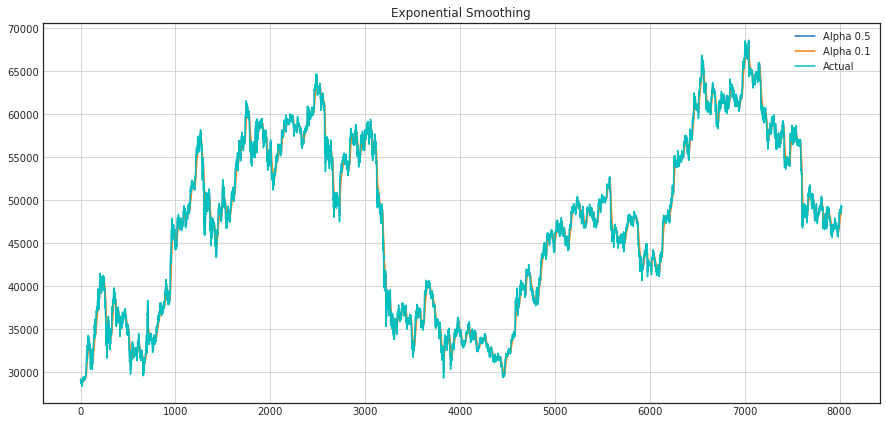

In [605]:
# Single exponential smoothing
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(data['Close'], [0.5, 0.1])

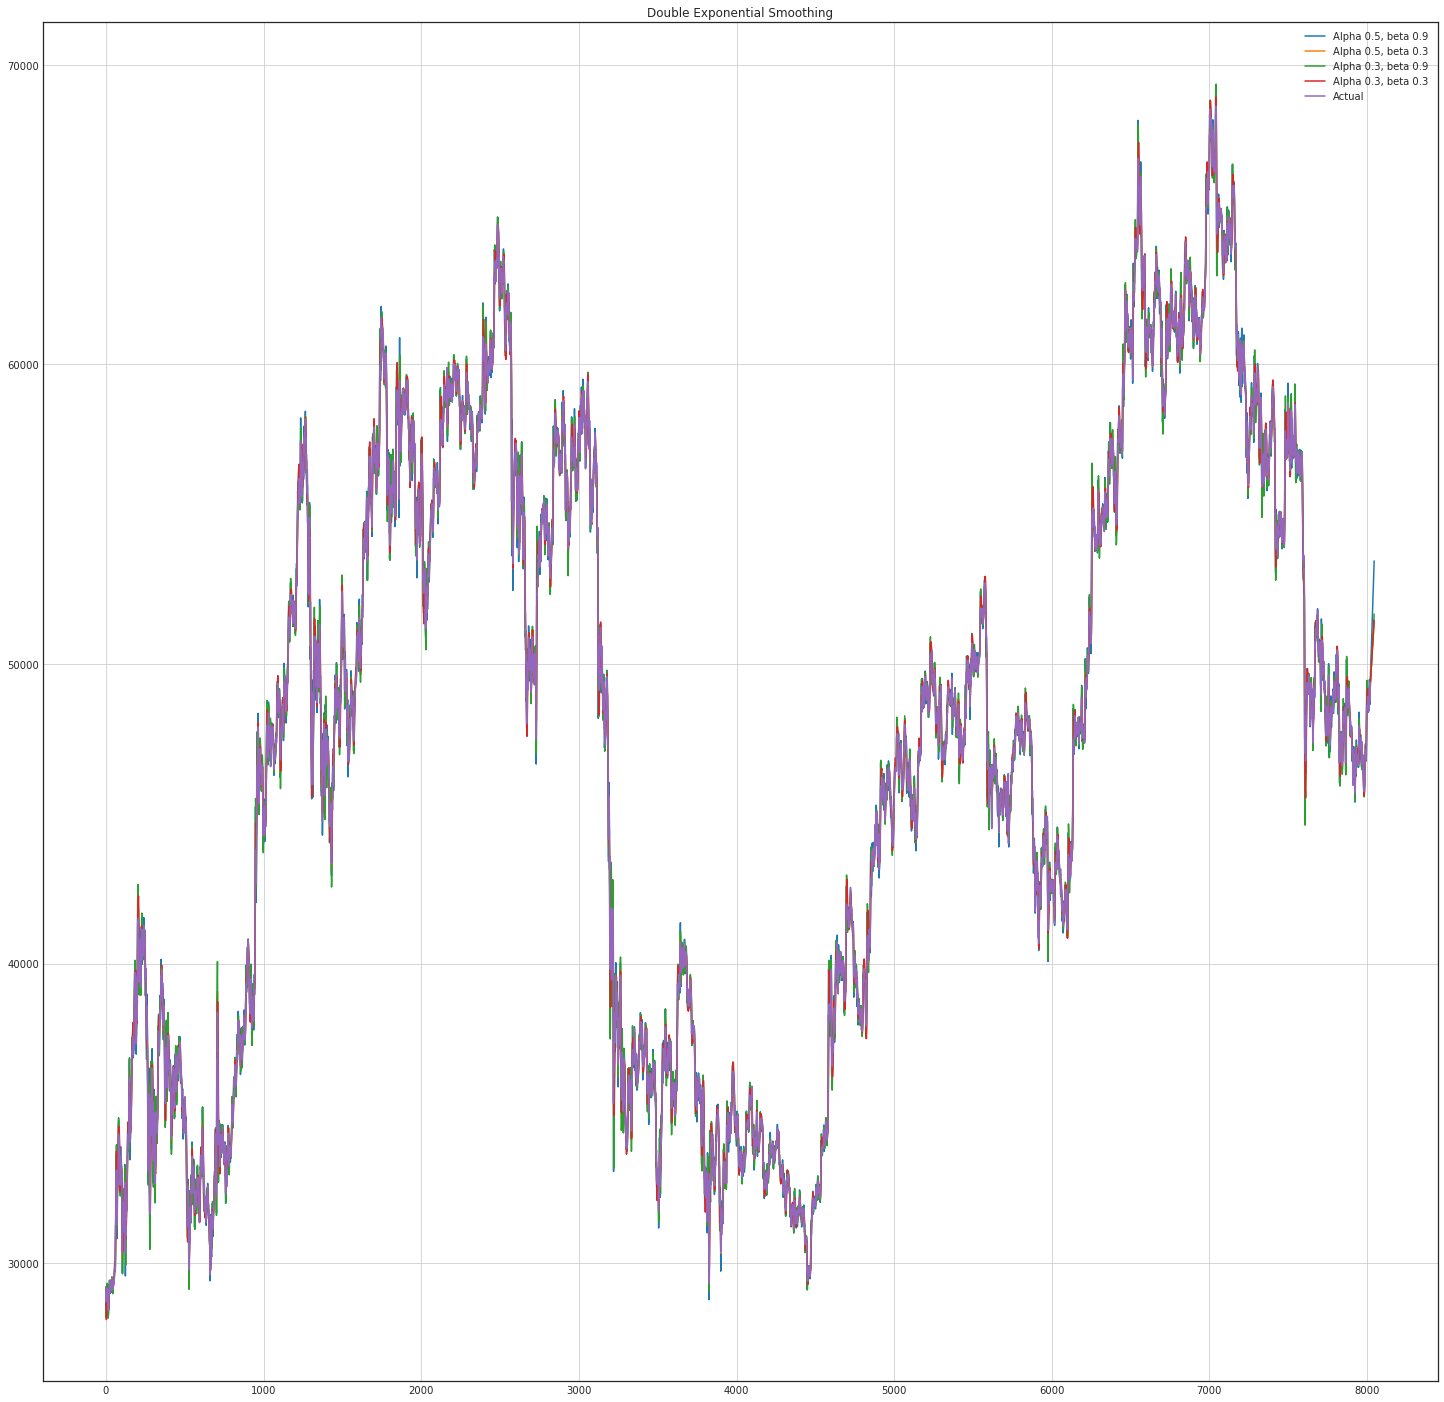

In [606]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+24):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(25, 25))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(data['Close'], alphas=[0.5,0.3], betas=[0.9,0.3])

In [607]:
#choosing alpha of .5 and beta of .9 as smoothing parameters

naive=double_exponential_smoothing(data['Close'], .5, .9)
naive

[29195.859375,
 28397.87890625,
 28292.616796875,
 28761.19236328125,
 29094.328348632815,
 29173.425732861328,
 29102.93196628174,
 29188.949096602664,
 29039.649904229427,
 28978.04671832707,
 29080.921758378703,
 29035.936479321605,
 28662.060900660836,
 28327.026760720575,
 28161.604874988687,
 28560.78970712783,
 28498.896383896128,
 28587.81871280827,
 28899.66682759437,
 29099.78280475745,
 29288.49497651064,
 29214.9897487387,
 29215.514404170313,
 29054.91985938448,
 28975.152400268544,
 29321.281926527234,
 29361.33622896932,
 29418.18483106042,
 29332.85007922253,
 29203.277218434698,
 29109.26379365142,
 29052.441010835395,
 29017.9250122077,
 29171.160523025388,
 29334.98162901031,
 29439.98716769813,
 29397.57715689038,
 29530.935868385834,
 29461.15218882868,
 29260.6951843897,
 29267.46263825734,
 29133.41952563161,
 29029.81142887827,
 29015.835889850125,
 29209.881051934746,
 29316.20969866892,
 29409.808466228744,
 29464.16845426822,
 29325.13455792976,
 29403.420144

In [608]:
naive=pd.DataFrame(naive)
naive

,0
0,29195.859375
1,28397.878906
2,28292.616797
3,28761.192363
4,29094.328349
...,...
8041,52790.092473
8042,52953.157054
8043,53116.221635
8044,53279.286216


## Create a 24 hour predictor for NB

In [609]:
naive['Naive']=naive[0].shift(-24)/naive[0]

In [610]:
naive=naive[['Naive']]

In [611]:
naive

,Naive
0,0.992440
1,1.032517
2,1.037774
3,1.022843
4,1.008198
...,...
8041,NaN
8042,NaN
8043,NaN
8044,NaN


In [612]:
naive=naive.reset_index()

In [613]:
data=data.reset_index()

In [614]:
naive=naive.drop('index', axis=1)

In [615]:
naive.tail(50)

,Naive
7996,1.030075
7997,1.010166
7998,1.005801
7999,1.012537
8000,1.023901
8001,1.033442
8002,1.039249
8003,1.039884
8004,1.037418
8005,1.039145


In [616]:
naive = naive.dropna()

In [617]:
data=data.merge(naive,left_index=True, right_index=True)
data

,Date,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,DGS1MO,...,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Naive
0,2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,0.08,...,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,0.010059,0.994398,0.0,0.992440
1,2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,0.08,...,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,1.021346,0.0,1.032517
2,2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,0.08,...,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,1.018174,0.0,1.037774
3,2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,0.08,...,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,1.009324,0.0,1.022843
4,2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,0.08,...,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,1.007925,0.0,1.008198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8017,2021-12-22,48747.562500,0.000000e+00,0.002853,57.898569,385.388075,-46.776468,432.164542,0.0,0.03,...,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,-0.005676,0.990072,0.0,1.081341
8018,2021-12-22,48824.265625,0.000000e+00,0.004230,59.090094,363.304811,-55.087785,418.392596,0.0,0.03,...,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,0.993425,0.0,1.088409
8019,2021-12-22,49385.519531,8.785449e+08,0.013378,66.550003,386.635274,-25.405857,412.041132,0.0,0.03,...,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,0.980440,-1.0,1.080058
8020,2021-12-22,49230.898438,0.000000e+00,0.007279,63.134417,388.173581,-19.094040,407.267622,0.0,0.03,...,0.002155,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,0.986653,-1.0,1.078776


In [618]:
data

,Date,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,DGS1MO,...,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Naive
0,2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,0.08,...,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,0.010059,0.994398,0.0,0.992440
1,2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,0.08,...,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,0.013818,1.021346,0.0,1.032517
2,2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,0.08,...,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,0.012849,1.018174,0.0,1.037774
3,2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,0.08,...,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,0.018664,1.009324,0.0,1.022843
4,2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,0.08,...,-0.001073,0.014021,0.011890,0.016525,0.025857,0.024448,0.023347,1.007925,0.0,1.008198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8017,2021-12-22,48747.562500,0.000000e+00,0.002853,57.898569,385.388075,-46.776468,432.164542,0.0,0.03,...,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,-0.005676,0.990072,0.0,1.081341
8018,2021-12-22,48824.265625,0.000000e+00,0.004230,59.090094,363.304811,-55.087785,418.392596,0.0,0.03,...,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,-0.003312,0.993425,0.0,1.088409
8019,2021-12-22,49385.519531,8.785449e+08,0.013378,66.550003,386.635274,-25.405857,412.041132,0.0,0.03,...,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,-0.002637,0.980440,-1.0,1.080058
8020,2021-12-22,49230.898438,0.000000e+00,0.007279,63.134417,388.173581,-19.094040,407.267622,0.0,0.03,...,0.002155,0.009695,0.012121,0.006973,0.003613,0.000277,-0.009965,0.986653,-1.0,1.078776


In [619]:
data['CHANGE']=(data['Naive'].shift(-24)/data['Naive'])

In [620]:
data['CHANGE'].max()

1.4464151061550568

In [621]:
data['CHANGE'].min()

0.7208170221083101

In [622]:
#ENCODE NAIVE BAYES PREDICTOR
data['Buy_Sell_Predict']=data.CHANGE.apply(lambda x: -1 if x <.99 else (1 if x >= 1.03 else 0))

In [623]:
data['Buy_Sell_Predict'].max()

1

In [624]:
data['Buy_Sell_Predict'].min()

-1

In [625]:
data

,Date,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,DGS1MO,...,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Naive,CHANGE,Buy_Sell_Predict
0,2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,0.08,...,0.023347,0.018664,0.012849,0.013818,0.010059,0.994398,0.0,0.992440,1.019788,0
1,2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,0.08,...,0.024448,0.023347,0.018664,0.012849,0.013818,1.021346,0.0,1.032517,0.971221,-1
2,2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,0.08,...,0.025857,0.024448,0.023347,0.018664,0.012849,1.018174,0.0,1.037774,0.966239,-1
3,2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,0.08,...,0.016525,0.025857,0.024448,0.023347,0.018664,1.009324,0.0,1.022843,0.978191,-1
4,2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,0.08,...,0.011890,0.016525,0.025857,0.024448,0.023347,1.007925,0.0,1.008198,0.994757,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8017,2021-12-22,48747.562500,0.000000e+00,0.002853,57.898569,385.388075,-46.776468,432.164542,0.0,0.03,...,0.000277,-0.009965,-0.002637,-0.003312,-0.005676,0.990072,0.0,1.081341,NaN,0
8018,2021-12-22,48824.265625,0.000000e+00,0.004230,59.090094,363.304811,-55.087785,418.392596,0.0,0.03,...,0.003613,0.000277,-0.009965,-0.002637,-0.003312,0.993425,0.0,1.088409,NaN,0
8019,2021-12-22,49385.519531,8.785449e+08,0.013378,66.550003,386.635274,-25.405857,412.041132,0.0,0.03,...,0.006973,0.003613,0.000277,-0.009965,-0.002637,0.980440,-1.0,1.080058,NaN,0
8020,2021-12-22,49230.898438,0.000000e+00,0.007279,63.134417,388.173581,-19.094040,407.267622,0.0,0.03,...,0.012121,0.006973,0.003613,0.000277,-0.009965,0.986653,-1.0,1.078776,NaN,0


In [626]:
data['Buy_Sell_Predict'].mean()

-0.14048865619546247

In [627]:
data['Buy_Sell_Predict'].mean()

-0.14048865619546247

In [628]:
from sklearn.preprocessing import OneHotEncoder


cat_attribs = ['Buy_Sell_Predict']

full_pipeline = ColumnTransformer( [
   
    ('cat', OneHotEncoder(sparse=False), cat_attribs)
])


data2= full_pipeline.fit_transform(data)


In [629]:
data2=pd.DataFrame(data2)

In [630]:
#rename naive bayes predictor
data2.columns=['SellPred','HoldPred','BuyPred']

In [631]:
data=data.reset_index()

In [632]:
data3=data.merge(data2,left_index=True,right_index=True)

In [633]:
data3=data3.dropna()

In [634]:
data=data3

In [635]:
data.head(50)

,index,Date,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,...,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Naive,CHANGE,Buy_Sell_Predict,SellPred,HoldPred,BuyPred
0,0,2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,...,0.013818,0.010059,0.994398,0.0,0.992440,1.019788,0,0.0,1.0,0.0
1,1,2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,...,0.012849,0.013818,1.021346,0.0,1.032517,0.971221,-1,1.0,0.0,0.0
2,2,2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,...,0.018664,0.012849,1.018174,0.0,1.037774,0.966239,-1,1.0,0.0,0.0
3,3,2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,...,0.023347,0.018664,1.009324,0.0,1.022843,0.978191,-1,1.0,0.0,0.0
4,4,2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,...,0.024448,0.023347,1.007925,0.0,1.008198,0.994757,0,0.0,1.0,0.0
5,5,2020-12-31,28964.285156,0.000000e+00,0.034835,63.878383,367.663091,-4.736984,372.400074,0.0,...,0.025857,0.024448,1.008101,0.0,1.001023,1.012786,0,0.0,1.0,0.0
6,6,2020-12-31,28947.517578,0.000000e+00,0.028459,63.361513,353.367492,-15.226066,368.593558,0.0,...,0.016525,0.025857,1.007693,0.0,1.000218,1.024770,0,0.0,1.0,0.0
7,7,2020-12-31,29148.781250,1.110950e+09,0.035226,66.830815,354.195478,-11.518464,365.713942,0.0,...,0.011890,0.016525,0.999390,0.0,0.995323,1.037111,1,0.0,0.0,1.0
8,8,2020-12-31,28965.378906,0.000000e+00,0.029522,61.148629,336.177383,-23.629247,359.806630,0.0,...,0.014021,0.011890,1.004212,0.0,0.999252,1.035150,1,0.0,0.0,1.0
9,9,2020-12-31,29014.292969,4.436705e+08,0.026589,62.074777,322.131538,-30.140074,352.271612,0.0,...,-0.001073,0.014021,1.007570,0.0,1.006664,1.016951,0,0.0,1.0,0.0


In [636]:
#Find class weights for unbalanced data (didn't need to use)

class_weights_dict = tf.constant([data['Buy/Hold/Sell'].mean(), 1.0 - data['Buy/Hold/Sell'].mean()])

In [637]:
class_weights_dict

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.12628157,  1.1262816 ], dtype=float32)>

In [638]:
data=data.dropna()

In [639]:


data

,index,Date,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,...,t_minus8_Change,t_minus9_Change,move,Buy/Hold/Sell,Naive,CHANGE,Buy_Sell_Predict,SellPred,HoldPred,BuyPred
0,0,2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,...,0.013818,0.010059,0.994398,0.0,0.992440,1.019788,0,0.0,1.0,0.0
1,1,2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,...,0.012849,0.013818,1.021346,0.0,1.032517,0.971221,-1,1.0,0.0,0.0
2,2,2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,...,0.018664,0.012849,1.018174,0.0,1.037774,0.966239,-1,1.0,0.0,0.0
3,3,2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,...,0.023347,0.018664,1.009324,0.0,1.022843,0.978191,-1,1.0,0.0,0.0
4,4,2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,...,0.024448,0.023347,1.007925,0.0,1.008198,0.994757,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7993,7993,2021-12-21,46820.820312,0.000000e+00,0.010958,53.829103,41.535833,113.164766,-71.628933,0.0,...,0.007412,0.001415,1.041151,1.0,1.044067,1.035701,1,0.0,0.0,1.0
7994,7994,2021-12-21,47019.152344,0.000000e+00,0.023561,56.834069,68.630317,112.207400,-43.577083,0.0,...,0.009978,0.007412,1.038391,1.0,1.037780,1.048786,1,0.0,0.0,1.0
7995,7995,2021-12-21,46947.171875,0.000000e+00,0.022939,55.424205,83.334046,101.528903,-18.194857,0.0,...,0.012016,0.009978,1.051938,1.0,1.047796,1.030791,1,0.0,0.0,1.0
7996,7996,2021-12-21,47976.976562,7.534551e+08,0.040534,67.750168,176.054047,155.399123,20.654924,0.0,...,0.008389,0.012016,1.026136,0.0,1.030075,1.047280,1,0.0,0.0,1.0


In [640]:
#test if NB predictor is in line with actual closes
data['VARIANCE0']=data['Buy/Hold/Sell']-data['Buy_Sell_Predict']


In [744]:
#Accuracy of NB

1- (data['VARIANCE0'].sum()/7998)

0.9853713428357089

In [642]:
list(data.columns)

['index',
 'Date',
 'Close',
 'Volume',
 'LOGRET_16',
 'RSI_14',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'WEEKDAY',
 'DGS1MO',
 'DGS3MO',
 'DGS1',
 'DGS3',
 'DGS10',
 'CPIopen',
 'CPIhigh',
 'CPIlow',
 'CPIclose',
 'CPIvolume',
 'CPIChange_Close',
 'CPIChange_Open',
 'CPIChange_high',
 'CPIChange_low',
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low',
 '24_TrailAvg',
 '48_TrailAvg',
 'Trail_Diff',
 'prior_volume_-1',
 'prior_volume_-2',
 'prior_volume_-3',
 'prior_volume_-4',
 'prior_volume_-5',
 'prior_volume_-6',
 'prior_volume_-7',
 'prior_volume_-8',
 'prior_volume_-9',
 'prior_volume_-10',
 'prior_volume_-11',


In [643]:
from sklearn.preprocessing import OneHotEncoder

#enocode actual buy sell predictor columns

cat_attribs = ['Buy/Hold/Sell']

full_pipeline = ColumnTransformer( [
   
    ('cat', OneHotEncoder(sparse=False), cat_attribs)
])


data_= full_pipeline.fit_transform(data)
data_

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [644]:
data_=pd.DataFrame(data_)
data_.rename({0:'SELL', 1: 'HOLD', 2: 'BUY'}, axis=1, inplace=True)

In [645]:
data_

,SELL,HOLD,BUY
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
7993,0.0,0.0,1.0
7994,0.0,0.0,1.0
7995,0.0,0.0,1.0
7996,0.0,1.0,0.0


In [646]:
data=data.merge(data_,how='inner',left_index=True,right_index=True)
data

,index,Date,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,WEEKDAY,...,Naive,CHANGE,Buy_Sell_Predict,SellPred,HoldPred,BuyPred,VARIANCE0,SELL,HOLD,BUY
0,0,2020-12-31,29195.859375,0.000000e+00,0.048759,76.628992,413.858510,53.218710,360.639799,0.0,...,0.992440,1.019788,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,2020-12-31,28796.869141,1.712116e+09,0.032637,63.606177,399.235842,30.876834,368.359008,0.0,...,1.032517,0.971221,-1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,2020-12-31,28707.066406,0.000000e+00,0.029965,61.089707,376.065888,6.165504,369.900384,0.0,...,1.037774,0.966239,-1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,2020-12-31,29059.386719,0.000000e+00,0.046486,66.662340,381.732464,9.465664,372.266800,0.0,...,1.022843,0.978191,-1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,2020-12-31,29022.187500,0.000000e+00,0.039628,65.594166,378.854402,5.270082,373.584320,0.0,...,1.008198,0.994757,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7993,7993,2021-12-21,46820.820312,0.000000e+00,0.010958,53.829103,41.535833,113.164766,-71.628933,0.0,...,1.044067,1.035701,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7994,7994,2021-12-21,47019.152344,0.000000e+00,0.023561,56.834069,68.630317,112.207400,-43.577083,0.0,...,1.037780,1.048786,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7995,7995,2021-12-21,46947.171875,0.000000e+00,0.022939,55.424205,83.334046,101.528903,-18.194857,0.0,...,1.047796,1.030791,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7996,7996,2021-12-21,47976.976562,7.534551e+08,0.040534,67.750168,176.054047,155.399123,20.654924,0.0,...,1.030075,1.047280,1,0.0,0.0,1.0,-1.0,0.0,1.0,0.0


In [842]:
from sklearn.preprocessing import MinMaxScaler

#scale the data using MinMaxScaler
#challenge  here is that we need to preserve the scaler used on the labeled data for future predictions
#as well as understanding how well the model is performing

#scaler used for features
scalerW = MinMaxScaler()
scalerX=MinMaxScaler()
scalerY= MinMaxScaler()

scalerZ= MinMaxScaler()


SCALER= MinMaxScaler()

scale1= MinMaxScaler()

scale2= MinMaxScaler()
scale3= MinMaxScaler()
scale4= MinMaxScaler()










scaled_data = np.concatenate([scalerW.fit_transform(data[[
    
  'Naive',                                                           
 'Trail_Diff'
]]), 
                              
                        
                              scalerX.fit_transform(data[[ 
                                  
'prior_volume_-1',
'prior_volume_-2',
'prior_volume_-3',
'prior_volume_-4',
'prior_volume_-5',
'prior_volume_-6',
'prior_volume_-7',
'prior_volume_-8',
'prior_volume_-9',
'prior_volume_-10',
'prior_volume_-11'
 ]]),
                              
                              scalerY.fit_transform(data[[ 
'HighDifferential',
'LowDifferential',
 'HighDifferentialMinus_1',
'LowDifferentialMinus_1',
 'HighDifferentialMinus_2',
'LowDifferentialMinus_2',
 'HighDifferentialMinus_3',
'LowDifferentialMinus_3',
 'HighDifferentialMinus_4',
'LowDifferentialMinus_4',                                 
'Momentum%',
'Momentum%Minus_1',
 'Momentum%Minus_2',
 'Momentum%Minus_3',
  'Momentum%Minus_4'
  ]]),
                              
                              
                              
                              
                              
                              
                              
                              scalerZ.fit_transform(data[[ 
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_Change',
 't_minus2_Change',
 't_minus3_Change',
 't_minus4_Change',
 't_minus5_Change',
 't_minus6_Change',
 't_minus7_Change',
 't_minus8_Change',
 't_minus9_Change',
 'CPIChange_Close',
 'CPIChange_Open',
 'CPIChange_high',
 'CPIChange_low',
                               
  
 ]]),
                                                            
                              scale1.fit_transform(data[[ 
                                  
'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9']]),
                              
                           scale2.fit_transform(data[[ 
                                  
'LOGRET_16']]),
                              scale3.fit_transform(data[[ 
                                  
'RSI_14']]),

                              
            
                              
                              
                              
                                 data[['WEEKDAY','SellPred','HoldPred','BuyPred','SELL','HOLD','BUY']] ], axis = 1)



In [843]:
#look at the shape of our scaled_data
scaled_data.shape

(7998, 58)

In [844]:
#take a look at the first 5 entries that will be the "features" for this model
scaled_data[0:5]

array([[0.47, 0.62, 0.88, 0.88, 0.88, 0.88, 0.98, 0.98, 0.98, 0.98, 0.98,
        0.98, 0.98, 0.16, 0.17, 0.15, 0.17, 0.13, 0.15, 0.12, 0.14, 0.12,
        0.14, 0.72, 0.72, 0.72, 0.72, 0.73, 0.57, 0.22, 0.04, 0.28, 0.46,
        0.47, 0.5 , 0.55, 0.57, 0.62, 0.61, 0.6 , 0.6 , 0.59, 0.56, 0.57,
        0.59, 0.7 , 0.65, 0.57, 0.64, 0.65, 0.81, 0.  , 0.  , 1.  , 0.  ,
        0.  , 1.  , 0.  ],
       [0.56, 0.63, 0.88, 0.88, 0.88, 0.88, 0.98, 0.98, 0.98, 0.98, 0.98,
        0.98, 0.98, 0.14, 0.16, 0.16, 0.17, 0.15, 0.17, 0.13, 0.15, 0.12,
        0.14, 0.7 , 0.7 , 0.73, 0.72, 0.72, 0.57, 0.22, 0.04, 0.28, 0.46,
        0.47, 0.48, 0.52, 0.58, 0.63, 0.62, 0.61, 0.6 , 0.6 , 0.56, 0.57,
        0.59, 0.7 , 0.65, 0.56, 0.64, 0.61, 0.65, 0.  , 1.  , 0.  , 0.  ,
        0.  , 1.  , 0.  ],
       [0.57, 0.63, 0.88, 0.88, 0.88, 0.88, 0.98, 0.98, 0.98, 0.98, 0.98,
        0.98, 0.98, 0.15, 0.16, 0.14, 0.16, 0.16, 0.17, 0.15, 0.17, 0.13,
        0.15, 0.64, 0.64, 0.72, 0.73, 0.72, 0.57, 0.22, 0.

In [845]:
#We want to predict what Bitcoins price will be in 24 hours from now

Y = pd.DataFrame(scaled_data[:,-3:])


In [846]:
Y.tail()

,0,1,2
7993,0.0,0.0,1.0
7994,0.0,0.0,1.0
7995,0.0,0.0,1.0
7996,0.0,1.0,0.0
7997,0.0,1.0,0.0


In [847]:
Y.dropna(inplace=True)


In [848]:
Y

,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
7993,0.0,0.0,1.0
7994,0.0,0.0,1.0
7995,0.0,0.0,1.0
7996,0.0,1.0,0.0


In [849]:
Y=Y.to_numpy()

In [850]:
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data[:,:-3],Y, test_size=0.1, random_state=42, shuffle = False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.5, random_state=42, shuffle = False)

In [810]:
STEPS = 5
trainSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_train, y_train, length=STEPS, batch_size=720)
testSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_test, y_test, length=STEPS, batch_size=720)
validSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_valid,y_valid,length=STEPS, batch_size=720)

# Detirmine Best HYPERPARAMETERS

In [831]:
#choosen Model used below

def getModel(optimizer):
    model = keras.models.Sequential()
    model.add(keras.layers.GRU(300, return_sequences=True, input_shape=(STEPS, 55)))
    model.add(keras.layers.GRU(480, return_sequences=True))
    model.add(keras.layers.Dropout(.1))
    model.add(keras.layers.GRU(600, return_sequences=True))
    model.add(keras.layers.Dropout(.15))
    model.add(keras.layers.GRU(720, return_sequences=True))
    model.add(keras.layers.Dropout(.2))
    model.add(keras.layers.GRU(1000, return_sequences=True))
    model.add(keras.layers.Dropout(.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=optimizer , loss = tf.keras.losses.CategoricalCrossentropy() , metrics=m)
    return model

In [832]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

In [833]:
trainSeries[0][0]

array([[[0.47, 0.62, 0.88, ..., 0.  , 1.  , 0.  ],
        [0.56, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.57, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.54, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.51, 0.63, 0.88, ..., 0.  , 1.  , 0.  ]],

       [[0.56, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.57, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.54, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.51, 0.63, 0.88, ..., 0.  , 1.  , 0.  ],
        [0.49, 0.63, 0.88, ..., 0.  , 1.  , 0.  ]],

       [[0.57, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.54, 0.63, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.51, 0.63, 0.88, ..., 0.  , 1.  , 0.  ],
        [0.49, 0.63, 0.88, ..., 0.  , 1.  , 0.  ],
        [0.49, 0.62, 0.88, ..., 0.  , 1.  , 0.  ]],

       ...,

       [[0.48, 0.76, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.47, 0.75, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.49, 0.74, 0.88, ..., 1.  , 0.  , 0.  ],
        [0.49, 0.73, 0.88, ..., 0.  , 1.  , 0.  ],
        [0.5

In [834]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

scorers = {'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)}

params={'batch_size':[180, 360, 720, 1080],'steps':[3,5,12,24],'optimizer':['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

Kmodel = KerasClassifier(build_fn=getModel, verbose=1)

gs=GridSearchCV(estimator=Kmodel, param_grid=params,scoring=scorers, cv=3,refit='precision_score')
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(trainSeries[0][0],trainSeries[0][1])

3/3 [==============================] - 6s 375ms/step - loss: 1.0992 - precision_at_recall: 0.7269


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 75ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 427ms/step - loss: 1.1010 - precision_at_recall: 0.4961


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 89ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 494ms/step - loss: 1.0993 - precision_at_recall: 0.4173


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 121ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 451ms/step - loss: 1.0971 - precision_at_recall: 0.4047


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 435ms/step - loss: 1.0988 - precision_at_recall: 0.3944


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 410ms/step - loss: 1.1005 - precision_at_recall: 0.3832


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 85ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 403ms/step - loss: 1.0980 - precision_at_recall: 0.3781


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 86ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 401ms/step - loss: 1.0977 - precision_at_recall: 0.3743


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 82ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 472ms/step - loss: 1.0985 - precision_at_recall: 0.3699


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 99ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 446ms/step - loss: 1.0990 - precision_at_recall: 0.3663


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 432ms/step - loss: 1.0991 - precision_at_recall: 0.3629


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 87ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 498ms/step - loss: 1.0999 - precision_at_recall: 0.3588


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 105ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 569ms/step - loss: 1.3189 - precision_at_recall: 0.3567


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 115ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 544ms/step - loss: 1.3474 - precision_at_recall: 0.3567


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 115ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 564ms/step - loss: 1.3772 - precision_at_recall: 0.3570


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 110ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 543ms/step - loss: 1.6228 - precision_at_recall: 0.3591


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 119ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 589ms/step - loss: 1.4574 - precision_at_recall: 0.3595


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 108ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 617ms/step - loss: 1.3555 - precision_at_recall: 0.3588


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 124ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 590ms/step - loss: 1.8849 - precision_at_recall: 0.3606


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 121ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 572ms/step - loss: 1.4291 - precision_at_recall: 0.3607


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 100ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 573ms/step - loss: 1.4340 - precision_at_recall: 0.3611


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 116ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 619ms/step - loss: 1.6350 - precision_at_recall: 0.3613


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 127ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 571ms/step - loss: 1.4252 - precision_at_recall: 0.3616


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 146ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 592ms/step - loss: 1.2359 - precision_at_recall: 0.3616


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 108ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 525ms/step - loss: 1.0967 - precision_at_recall: 0.3621


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 116ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 548ms/step - loss: 1.0992 - precision_at_recall: 0.3607


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 119ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 543ms/step - loss: 1.0952 - precision_at_recall: 0.3605


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 120ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 560ms/step - loss: 1.0953 - precision_at_recall: 0.3614


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 127ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 525ms/step - loss: 1.1002 - precision_at_recall: 0.3595


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 104ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 514ms/step - loss: 1.0992 - precision_at_recall: 0.3580


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 105ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 487ms/step - loss: 1.0978 - precision_at_recall: 0.3575


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 105ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 485ms/step - loss: 1.0969 - precision_at_recall: 0.3575


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 106ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 480ms/step - loss: 1.0993 - precision_at_recall: 0.3565


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 109ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 483ms/step - loss: 1.0962 - precision_at_recall: 0.3565


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 103ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 475ms/step - loss: 1.0997 - precision_at_recall: 0.3559


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 105ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 467ms/step - loss: 1.0982 - precision_at_recall: 0.3554


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 100ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 465ms/step - loss: 1.0986 - precision_at_recall: 0.3547


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 100ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 469ms/step - loss: 1.0972 - precision_at_recall: 0.3546


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 503ms/step - loss: 1.0994 - precision_at_recall: 0.3540


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 109ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 463ms/step - loss: 1.0977 - precision_at_recall: 0.3537


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 103ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 470ms/step - loss: 1.0980 - precision_at_recall: 0.3535


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 101ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 443ms/step - loss: 1.1020 - precision_at_recall: 0.3528


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 428ms/step - loss: 1.0988 - precision_at_recall: 0.3523


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 435ms/step - loss: 1.0985 - precision_at_recall: 0.3519


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 431ms/step - loss: 1.0985 - precision_at_recall: 0.3515


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 429ms/step - loss: 1.1027 - precision_at_recall: 0.3501


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 89ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 426ms/step - loss: 1.0974 - precision_at_recall: 0.3499


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 427ms/step - loss: 1.0982 - precision_at_recall: 0.3499


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 430ms/step - loss: 1.1180 - precision_at_recall: 0.3499


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 429ms/step - loss: 1.1270 - precision_at_recall: 0.3500


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 424ms/step - loss: 1.1173 - precision_at_recall: 0.3499


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 427ms/step - loss: 1.1077 - precision_at_recall: 0.3495


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 94ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 423ms/step - loss: 1.1295 - precision_at_recall: 0.3494


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 424ms/step - loss: 1.1185 - precision_at_recall: 0.3491


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 429ms/step - loss: 1.1140 - precision_at_recall: 0.3487


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 433ms/step - loss: 1.1184 - precision_at_recall: 0.3485


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 89ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 442ms/step - loss: 1.1243 - precision_at_recall: 0.3485


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 94ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 439ms/step - loss: 1.1251 - precision_at_recall: 0.3483


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 438ms/step - loss: 1.1212 - precision_at_recall: 0.3481


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 95ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 429ms/step - loss: 1.1142 - precision_at_recall: 0.3477


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 452ms/step - loss: 1.1272 - precision_at_recall: 0.3476


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 450ms/step - loss: 1.1193 - precision_at_recall: 0.3472


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 95ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 450ms/step - loss: 1.1215 - precision_at_recall: 0.3472


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 101ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 432ms/step - loss: 1.1244 - precision_at_recall: 0.3475


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 100ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 440ms/step - loss: 1.1153 - precision_at_recall: 0.3473


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 447ms/step - loss: 1.1204 - precision_at_recall: 0.3473


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 439ms/step - loss: 1.1222 - precision_at_recall: 0.3473


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 424ms/step - loss: 1.1213 - precision_at_recall: 0.3474


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 428ms/step - loss: 1.1176 - precision_at_recall: 0.3474


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 433ms/step - loss: 1.1267 - precision_at_recall: 0.3475


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 6s 441ms/step - loss: 1.1284 - precision_at_recall: 0.3475


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 425ms/step - loss: 1.1294 - precision_at_recall: 0.3477


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 502ms/step - loss: 1.1229 - precision_at_recall: 0.3473


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 494ms/step - loss: 1.1279 - precision_at_recall: 0.3475


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 484ms/step - loss: 1.1306 - precision_at_recall: 0.3473


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 89ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 494ms/step - loss: 1.1264 - precision_at_recall: 0.3469


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 507ms/step - loss: 1.1341 - precision_at_recall: 0.3468


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 97ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 497ms/step - loss: 1.1259 - precision_at_recall: 0.3467


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 94ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 500ms/step - loss: 1.1298 - precision_at_recall: 0.3467


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 513ms/step - loss: 1.1418 - precision_at_recall: 0.3467


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 95ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 534ms/step - loss: 1.1156 - precision_at_recall: 0.3465


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 99ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 497ms/step - loss: 1.1291 - precision_at_recall: 0.3466


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 504ms/step - loss: 1.1288 - precision_at_recall: 0.3463


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 97ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

3/3 [==============================] - 7s 494ms/step - loss: 1.1292 - precision_at_recall: 0.3461


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 363ms/step - loss: 1.0994 - precision_at_recall: 0.3456


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 361ms/step - loss: 1.0998 - precision_at_recall: 0.3453


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 372ms/step - loss: 1.0999 - precision_at_recall: 0.3449


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 359ms/step - loss: 1.0968 - precision_at_recall: 0.3450


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 370ms/step - loss: 1.0977 - precision_at_recall: 0.3450


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 349ms/step - loss: 1.0995 - precision_at_recall: 0.3448


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 358ms/step - loss: 1.0949 - precision_at_recall: 0.3452


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 353ms/step - loss: 1.0972 - precision_at_recall: 0.3454


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 364ms/step - loss: 1.0958 - precision_at_recall: 0.3457


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 352ms/step - loss: 1.1011 - precision_at_recall: 0.3453


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 6s 365ms/step - loss: 1.0994 - precision_at_recall: 0.3450


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 8s 436ms/step - loss: 1.0973 - precision_at_recall: 0.3452


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 10s 443ms/step - loss: 1.2742 - precision_at_recall: 0.3457


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 8s 497ms/step - loss: 1.1628 - precision_at_recall: 0.3456


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 8s 491ms/step - loss: 1.1501 - precision_at_recall: 0.3456


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 481ms/step - loss: 1.1527 - precision_at_recall: 0.3454


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 476ms/step - loss: 1.1996 - precision_at_recall: 0.3452


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 454ms/step - loss: 1.0990 - precision_at_recall: 0.3451


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 439ms/step - loss: 1.2346 - precision_at_recall: 0.3454


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 436ms/step - loss: 1.1887 - precision_at_recall: 0.3453


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 441ms/step - loss: 1.1055 - precision_at_recall: 0.3452


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 432ms/step - loss: 1.3829 - precision_at_recall: 0.3456


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 433ms/step - loss: 1.1986 - precision_at_recall: 0.3456


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 440ms/step - loss: 1.1619 - precision_at_recall: 0.3458


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 418ms/step - loss: 1.1034 - precision_at_recall: 0.3452


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 402ms/step - loss: 1.0989 - precision_at_recall: 0.3450


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 394ms/step - loss: 1.0989 - precision_at_recall: 0.3449


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 407ms/step - loss: 1.0975 - precision_at_recall: 0.3449


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 402ms/step - loss: 1.0976 - precision_at_recall: 0.3450


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 404ms/step - loss: 1.0993 - precision_at_recall: 0.3448


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 397ms/step - loss: 1.1007 - precision_at_recall: 0.3442


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 400ms/step - loss: 1.1006 - precision_at_recall: 0.3438


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 396ms/step - loss: 1.1000 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 401ms/step - loss: 1.0947 - precision_at_recall: 0.3436


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 397ms/step - loss: 1.0993 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 406ms/step - loss: 1.0995 - precision_at_recall: 0.3434


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 401ms/step - loss: 1.0985 - precision_at_recall: 0.3434


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 404ms/step - loss: 1.0993 - precision_at_recall: 0.3432


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 409ms/step - loss: 1.0976 - precision_at_recall: 0.3433


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 411ms/step - loss: 1.0985 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 408ms/step - loss: 1.0993 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 421ms/step - loss: 1.0977 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 423ms/step - loss: 1.0983 - precision_at_recall: 0.3430


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 424ms/step - loss: 1.0981 - precision_at_recall: 0.3430


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 420ms/step - loss: 1.0999 - precision_at_recall: 0.3427


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 429ms/step - loss: 1.0953 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 436ms/step - loss: 1.0984 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 432ms/step - loss: 1.0987 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 417ms/step - loss: 1.0967 - precision_at_recall: 0.3427


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 418ms/step - loss: 1.1119 - precision_at_recall: 0.3427


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 425ms/step - loss: 1.0904 - precision_at_recall: 0.3427


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 413ms/step - loss: 1.0928 - precision_at_recall: 0.3430


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 407ms/step - loss: 1.1054 - precision_at_recall: 0.3428


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 421ms/step - loss: 1.0884 - precision_at_recall: 0.3430


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 433ms/step - loss: 1.0964 - precision_at_recall: 0.3428


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 448ms/step - loss: 1.1109 - precision_at_recall: 0.3427


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 422ms/step - loss: 1.0884 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 419ms/step - loss: 1.0956 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 415ms/step - loss: 1.1085 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 412ms/step - loss: 1.0886 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 419ms/step - loss: 1.0980 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 421ms/step - loss: 1.1131 - precision_at_recall: 0.3432


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 416ms/step - loss: 1.0884 - precision_at_recall: 0.3433


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 420ms/step - loss: 1.0996 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 422ms/step - loss: 1.1164 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 409ms/step - loss: 1.0893 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 425ms/step - loss: 1.0945 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 425ms/step - loss: 1.1183 - precision_at_recall: 0.3434


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 440ms/step - loss: 1.0883 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 432ms/step - loss: 1.1051 - precision_at_recall: 0.3438


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 433ms/step - loss: 1.1133 - precision_at_recall: 0.3437


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 417ms/step - loss: 1.0904 - precision_at_recall: 0.3438


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 486ms/step - loss: 1.0969 - precision_at_recall: 0.3438


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 8s 525ms/step - loss: 1.1188 - precision_at_recall: 0.3439


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 527ms/step - loss: 1.0894 - precision_at_recall: 0.3440


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 529ms/step - loss: 1.0987 - precision_at_recall: 0.3439


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 8s 531ms/step - loss: 1.1193 - precision_at_recall: 0.3440


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 523ms/step - loss: 1.0859 - precision_at_recall: 0.3441


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 537ms/step - loss: 1.0931 - precision_at_recall: 0.3441


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 515ms/step - loss: 1.1095 - precision_at_recall: 0.3441


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 523ms/step - loss: 1.0907 - precision_at_recall: 0.3442


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 528ms/step - loss: 1.0948 - precision_at_recall: 0.3442


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 529ms/step - loss: 1.1161 - precision_at_recall: 0.3444


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

2/2 [==============================] - 7s 513ms/step - loss: 1.0891 - precision_at_recall: 0.3444


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0979 - precision_at_recall: 0.3445


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0981 - precision_at_recall: 0.3445


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0997 - precision_at_recall: 0.3442


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0986 - precision_at_recall: 0.3442


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0968 - precision_at_recall: 0.3443


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1003 - precision_at_recall: 0.3441


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1013 - precision_at_recall: 0.3437


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0981 - precision_at_recall: 0.3437


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0991 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0976 - precision_at_recall: 0.3436


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0983 - precision_at_recall: 0.3436


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0980 - precision_at_recall: 0.3436


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0976 - precision_at_recall: 0.3437


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0962 - precision_at_recall: 0.3438


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1007 - precision_at_recall: 0.3436


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1000 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0978 - precision_at_recall: 0.3435


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0996 - precision_at_recall: 0.3433


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0995 - precision_at_recall: 0.3432


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0991 - precision_at_recall: 0.3430


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0970 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0960 - precision_at_recall: 0.3432


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0971 - precision_at_recall: 0.3432


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0967 - precision_at_recall: 0.3433


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0979 - precision_at_recall: 0.3433


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3432


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3431


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1016 - precision_at_recall: 0.3427


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1004 - precision_at_recall: 0.3426


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0976 - precision_at_recall: 0.3426


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0935 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0992 - precision_at_recall: 0.3428


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0978 - precision_at_recall: 0.3429


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1013 - precision_at_recall: 0.3426


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0980 - precision_at_recall: 0.3426


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0995 - precision_at_recall: 0.3425


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0967 - precision_at_recall: 0.3426


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0993 - precision_at_recall: 0.3426


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0995 - precision_at_recall: 0.3425


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0973 - precision_at_recall: 0.3425


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0985 - precision_at_recall: 0.3425


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1000 - precision_at_recall: 0.3424


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3424


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0992 - precision_at_recall: 0.3423


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3422


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0939 - precision_at_recall: 0.3424


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0995 - precision_at_recall: 0.3423


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0987 - precision_at_recall: 0.3423


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1007 - precision_at_recall: 0.3420


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0981 - precision_at_recall: 0.3421


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0982 - precision_at_recall: 0.3420


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3419


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0982 - precision_at_recall: 0.3419


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0969 - precision_at_recall: 0.3420


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0997 - precision_at_recall: 0.3419


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1007 - precision_at_recall: 0.3417


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0979 - precision_at_recall: 0.3417


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0999 - precision_at_recall: 0.3416


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0992 - precision_at_recall: 0.3415


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0991 - precision_at_recall: 0.3414


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1012 - precision_at_recall: 0.3412


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3411


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0981 - precision_at_recall: 0.3412


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3411


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3411


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1002 - precision_at_recall: 0.3410


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0972 - precision_at_recall: 0.3410


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0984 - precision_at_recall: 0.3410


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1009 - precision_at_recall: 0.3409


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0997 - precision_at_recall: 0.3408


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0992 - precision_at_recall: 0.3408


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0980 - precision_at_recall: 0.3409


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0994 - precision_at_recall: 0.3407


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0983 - precision_at_recall: 0.3407


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0993 - precision_at_recall: 0.3406


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0984 - precision_at_recall: 0.3406


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0983 - precision_at_recall: 0.3407


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0977 - precision_at_recall: 0.3407


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0955 - precision_at_recall: 0.3408


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1003 - precision_at_recall: 0.3407


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0992 - precision_at_recall: 0.3406


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0986 - precision_at_recall: 0.3406


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0996 - precision_at_recall: 0.3405


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0989 - precision_at_recall: 0.3405


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0983 - precision_at_recall: 0.3405


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0988 - precision_at_recall: 0.3405


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1009 - precision_at_recall: 0.3403


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0976 - precision_at_recall: 0.3404


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0992 - precision_at_recall: 0.3403


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0982 - precision_at_recall: 0.3403


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0983 - precision_at_recall: 0.3403


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0993 - precision_at_recall: 0.3402


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0998 - precision_at_recall: 0.3401


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0956 - precision_at_recall: 0.3403


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0974 - precision_at_recall: 0.3403


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0992 - precision_at_recall: 0.3402


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1001 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0978 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0977 - precision_at_recall: 0.3401


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1009 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0983 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0981 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1019 - precision_at_recall: 0.3398


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0968 - precision_at_recall: 0.3398


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3398


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0964 - precision_at_recall: 0.3399


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0982 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0969 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0955 - precision_at_recall: 0.3401


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0998 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0985 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0981 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0998 - precision_at_recall: 0.3399


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0969 - precision_at_recall: 0.3400


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1009 - precision_at_recall: 0.3399


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3399


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1022 - precision_at_recall: 0.3397


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0992 - precision_at_recall: 0.3397


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3397


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1000 - precision_at_recall: 0.3395


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1015 - precision_at_recall: 0.3394


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0986 - precision_at_recall: 0.3393


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3393


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0985 - precision_at_recall: 0.3393


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0985 - precision_at_recall: 0.3393


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3393


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1009 - precision_at_recall: 0.3391


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0984 - precision_at_recall: 0.3390


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0971 - precision_at_recall: 0.3391


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0979 - precision_at_recall: 0.3392


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0985 - precision_at_recall: 0.3391


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0996 - precision_at_recall: 0.3390


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1010 - precision_at_recall: 0.3389


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1017 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0957 - precision_at_recall: 0.3389


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0951 - precision_at_recall: 0.3390


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0984 - precision_at_recall: 0.3390


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0988 - precision_at_recall: 0.3390


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1028 - precision_at_recall: 0.3387


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0982 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0986 - precision_at_recall: 0.3387


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0951 - precision_at_recall: 0.3389


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0970 - precision_at_recall: 0.3389


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0987 - precision_at_recall: 0.3389


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0995 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0976 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0991 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0959 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1008 - precision_at_recall: 0.3388


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0989 - precision_at_recall: 0.3387


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.1007 - precision_at_recall: 0.3386


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0975 - precision_at_recall: 0.3386


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0996 - precision_at_recall: 0.3385


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0965 - precision_at_recall: 0.3386


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0990 - precision_at_recall: 0.3386


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 6s 6s/step - loss: 1.0998 - precision_at_recall: 0.3385


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1033 - precision_at_recall: 0.3382


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0974 - precision_at_recall: 0.3383


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.1001 - precision_at_recall: 0.3382


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0998 - precision_at_recall: 0.3381


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0995 - precision_at_recall: 0.3380


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0964 - precision_at_recall: 0.3381


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0948 - precision_at_recall: 0.3383


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0992 - precision_at_recall: 0.3382


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0992 - precision_at_recall: 0.3382


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0923 - precision_at_recall: 0.3384


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0994 - precision_at_recall: 0.3383


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

1/1 [==============================] - 7s 7s/step - loss: 1.0987 - precision_at_recall: 0.3383


C:\Users\Mary Jane\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 1s 1s/step


C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Mary Jane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1653, in precision_score
    p, _, _, _ = pr

4/4 [==============================] - 7s 601ms/step - loss: 1.1005 - precision_at_recall: 0.3382


In [841]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))

Best: nan using {'batch_size': 180, 'optimizer': 'SGD', 'steps': 3}


In [851]:
STEPS = 3
trainSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_train, y_train, length=STEPS, batch_size=180)
testSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_test, y_test, length=STEPS, batch_size=180)
validSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_valid,y_valid,length=STEPS, batch_size=180)

In [852]:
trainSeries[0][0].shape

(180, 3, 55)

In [853]:
y_train=pd.DataFrame(y_train)

In [854]:
y_train

,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
3594,0.0,1.0,0.0
3595,0.0,1.0,0.0
3596,0.0,1.0,0.0
3597,0.0,1.0,0.0


In [855]:

for i in range(3):
    a,b= trainSeries[i]
    print('%s => %s' % (a, b))

[[[0.47 0.62 0.88 ... 0.   1.   0.  ]
  [0.56 0.63 0.88 ... 1.   0.   0.  ]
  [0.57 0.63 0.88 ... 1.   0.   0.  ]]

 [[0.56 0.63 0.88 ... 1.   0.   0.  ]
  [0.57 0.63 0.88 ... 1.   0.   0.  ]
  [0.54 0.63 0.88 ... 1.   0.   0.  ]]

 [[0.57 0.63 0.88 ... 1.   0.   0.  ]
  [0.54 0.63 0.88 ... 1.   0.   0.  ]
  [0.51 0.63 0.88 ... 0.   1.   0.  ]]

 ...

 [[0.75 0.7  0.88 ... 1.   0.   0.  ]
  [0.73 0.69 0.88 ... 1.   0.   0.  ]
  [0.69 0.69 0.88 ... 1.   0.   0.  ]]

 [[0.73 0.69 0.88 ... 1.   0.   0.  ]
  [0.69 0.69 0.88 ... 1.   0.   0.  ]
  [0.65 0.7  0.88 ... 1.   0.   0.  ]]

 [[0.69 0.69 0.88 ... 1.   0.   0.  ]
  [0.65 0.7  0.88 ... 1.   0.   0.  ]
  [0.58 0.7  0.88 ... 1.   0.   0.  ]]] => [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1.

# LSTM

In [904]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [905]:


model = keras.models.Sequential([
    keras.layers.GRU(300, return_sequences=True,input_shape=(STEPS, 55)),
    keras.layers.GRU(480, return_sequences=True),
    keras.layers.Dropout(.1),
    keras.layers.GRU(600, return_sequences=True),
    keras.layers.Dropout(.15),
    keras.layers.GRU(720, return_sequences=True),
    keras.layers.Dropout(.2),
    keras.layers.GRU(1000, return_sequences=True),
    keras.layers.Dropout(.25),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation="softmax")
])
    
    
    
    


In [906]:
model.output.shape

TensorShape([None, 3])

In [907]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 300)            321300    
_________________________________________________________________
gru_1 (GRU)                  (None, 3, 480)            1126080   
_________________________________________________________________
dropout (Dropout)            (None, 3, 480)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 3, 600)            1947600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 600)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 3, 720)            2855520   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 720)            0

In [908]:
#optional for unbalanced data, I didnt use

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = tf.keras.backend.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*tf.keras.backend.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * tf.keras.backend.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = tf.keras.backend.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [909]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [910]:

early_stopping2 = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1)


In [911]:
from focal_loss import BinaryFocalLoss

m = tf.keras.metrics.PrecisionAtRecall(0.5)
m.update_state([0, 0, 0, 1, 1], [0, 0.3, 0.8, 0.3, 0.8])
m.result().numpy()


k = tf.keras.metrics.SensitivityAtSpecificity(0.5)
k.update_state([0, 0, 0, 1, 1], [0, 0.3, 0.8, 0.3, 0.8])
k.result().numpy()

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=keras.optimizers.Adam(lr=0.0001), metrics=[tf.keras.metrics.AUC(),k,m])

In [912]:
#run for 173 epochs
history = model.fit(trainSeries, epochs=500, shuffle=False, 
                    validation_data=validSeries, callbacks=early_stopping2)

Epoch 1/500
20/20 [==============================] - 20s 728ms/step - loss: 1.0989 - auc: 0.5036 - sensitivity_at_specificity: 0.3357 - precision_at_recall: 0.3460 - val_loss: 1.0640 - val_auc: 0.6374 - val_sensitivity_at_specificity: 0.6043 - val_precision_at_recall: 0.4134
Epoch 2/500
20/20 [==============================] - 13s 675ms/step - loss: 1.0860 - auc: 0.5596 - sensitivity_at_specificity: 0.4716 - precision_at_recall: 0.3738 - val_loss: 1.0116 - val_auc: 0.6803 - val_sensitivity_at_specificity: 0.7392 - val_precision_at_recall: 0.4835
Epoch 3/500
20/20 [==============================] - 14s 691ms/step - loss: 1.0415 - auc: 0.6185 - sensitivity_at_specificity: 0.6305 - precision_at_recall: 0.4114 - val_loss: 1.0628 - val_auc: 0.6602 - val_sensitivity_at_specificity: 0.6897 - val_precision_at_recall: 0.4555
Epoch 4/500
20/20 [==============================] - 14s 698ms/step - loss: 1.0798 - auc: 0.6444 - sensitivity_at_specificity: 0.7236 - precision_at_recall: 0.4481 - val_lo

Epoch 31/500
20/20 [==============================] - 14s 718ms/step - loss: 0.5508 - auc: 0.9179 - sensitivity_at_specificity: 0.9820 - precision_at_recall: 0.8880 - val_loss: 0.5309 - val_auc: 0.9233 - val_sensitivity_at_specificity: 0.9875 - val_precision_at_recall: 0.8657
Epoch 32/500
20/20 [==============================] - 14s 714ms/step - loss: 0.5475 - auc: 0.9192 - sensitivity_at_specificity: 0.9811 - precision_at_recall: 0.8910 - val_loss: 0.5115 - val_auc: 0.9260 - val_sensitivity_at_specificity: 0.9892 - val_precision_at_recall: 0.8735
Epoch 33/500
20/20 [==============================] - 14s 719ms/step - loss: 0.5474 - auc: 0.9200 - sensitivity_at_specificity: 0.9815 - precision_at_recall: 0.8865 - val_loss: 0.4999 - val_auc: 0.9305 - val_sensitivity_at_specificity: 0.9894 - val_precision_at_recall: 0.8869
Epoch 34/500
20/20 [==============================] - 15s 757ms/step - loss: 0.5506 - auc: 0.9181 - sensitivity_at_specificity: 0.9812 - precision_at_recall: 0.8841 - va

Epoch 61/500
20/20 [==============================] - 14s 731ms/step - loss: 0.4368 - auc: 0.9463 - sensitivity_at_specificity: 0.9932 - precision_at_recall: 0.9377 - val_loss: 0.4171 - val_auc: 0.9493 - val_sensitivity_at_specificity: 0.9933 - val_precision_at_recall: 0.9295
Epoch 62/500
20/20 [==============================] - 14s 724ms/step - loss: 0.4378 - auc: 0.9463 - sensitivity_at_specificity: 0.9938 - precision_at_recall: 0.9394 - val_loss: 0.4150 - val_auc: 0.9506 - val_sensitivity_at_specificity: 0.9903 - val_precision_at_recall: 0.9320
Epoch 63/500
20/20 [==============================] - 14s 721ms/step - loss: 0.4420 - auc: 0.9461 - sensitivity_at_specificity: 0.9914 - precision_at_recall: 0.9382 - val_loss: 0.4183 - val_auc: 0.9488 - val_sensitivity_at_specificity: 0.9936 - val_precision_at_recall: 0.9261
Epoch 64/500
20/20 [==============================] - 14s 721ms/step - loss: 0.4402 - auc: 0.9458 - sensitivity_at_specificity: 0.9923 - precision_at_recall: 0.9372 - va

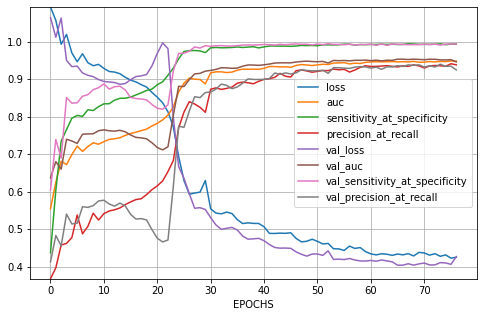

In [913]:
#plot the learning curve of the model
plot_learning_curve(history)
plt.show()

In [914]:
y_pred = model.predict(testSeries)
y_pred

array([[3.20e-01, 6.70e-01, 9.32e-03],
       [3.36e-01, 6.58e-01, 5.98e-03],
       [1.93e-01, 7.95e-01, 1.22e-02],
       ...,
       [1.41e-03, 3.82e-01, 6.16e-01],
       [1.93e-04, 1.25e-01, 8.75e-01],
       [6.31e-03, 5.73e-01, 4.20e-01]], dtype=float32)

In [915]:
y_pred=pd.DataFrame(y_pred)

In [916]:
 y_pred[0].max()

0.9999240636825562

In [917]:
 y_pred[1].max()

0.9518174529075623

In [918]:
 y_pred[2].max()

0.9950383305549622

In [919]:
model.evaluate(testSeries)

5/5 [==============================] - 1s 184ms/step - loss: 0.4507 - auc: 0.9404 - sensitivity_at_specificity: 0.9937 - precision_at_recall: 0.8956


[0.4506509006023407,
 0.9404491186141968,
 0.9937264919281006,
 0.8955555558204651]

In [920]:
y_pred.shape

(797, 3)

In [921]:
y_test.shape

(800, 3)

In [922]:


y_pred = np.append(y_pred, np.array([[0,1,0]]), axis=0)
y_pred = np.append(y_pred, np.array([[0,1,0]]), axis=0)
y_pred = np.append(y_pred, np.array([[0,1,0]]), axis=0)



In [923]:
from sklearn.metrics import confusion_matrix

In [924]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = .5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [925]:
from sklearn.metrics import confusion_matrix


Actuals=y_test[:,:].argmax(axis=1)
y_pred2=y_pred[:,:].argmax(axis=1)




matrix = confusion_matrix(Actuals, y_pred2)
np.set_printoptions(precision=2)

In [926]:
#test set = 800 hours (rows)
matrix

array([[258,  42,   1],
       [ 87, 288,   9],
       [  2,  42,  71]], dtype=int64)

In [927]:
classes=['Sell','Hold','Buy']

Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.23 0.75 0.02]
 [0.02 0.37 0.62]]


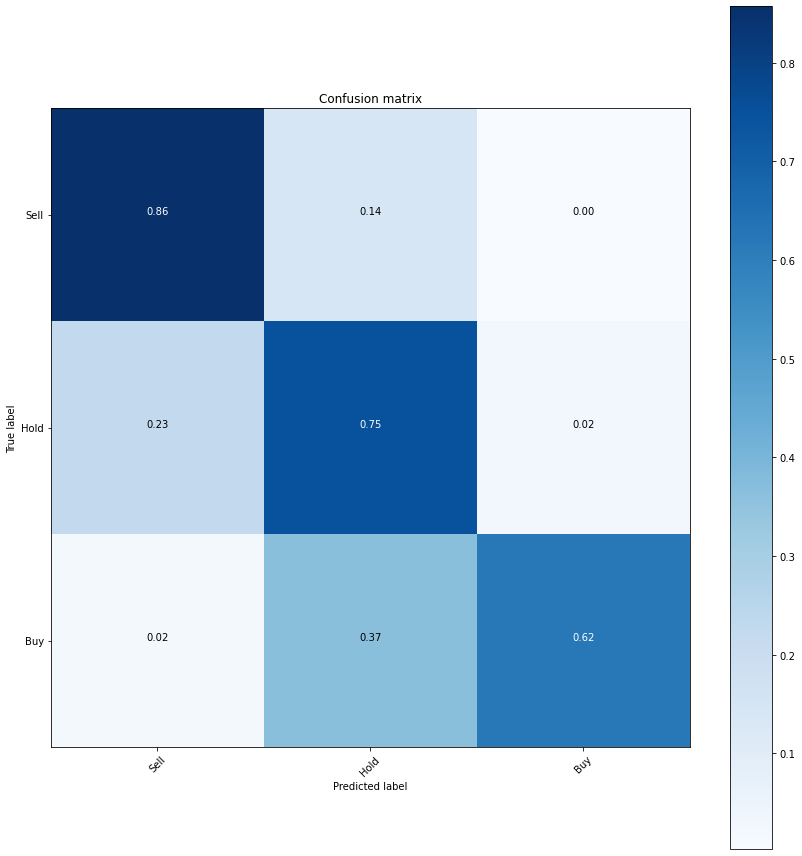

In [928]:
import itertools

plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(matrix, classes=classes,normalize=True,
                      title='Confusion matrix')

In [929]:
from sklearn.metrics import classification_report

print(classification_report (Actuals, y_pred2))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       301
           1       0.77      0.75      0.76       384
           2       0.88      0.62      0.72       115

    accuracy                           0.77       800
   macro avg       0.80      0.74      0.76       800
weighted avg       0.78      0.77      0.77       800



In [930]:
model.save("Bitcoin_BuySell.h5")

In [ ]:
def collectingLatestBTC(timePeriod="5y"):
    r = requests.get("https://api.coinranking.com/v2/coin/Qwsogvtv82FCd/history?timePeriod=" + timePeriod)
    latest_coin = json.loads(r.text)["data"]["history"]  # Reading the JSON and cleaning the irrelevant parts
    df = pd.DataFrame(latest_coin) #Creating the dataframe
    # print(df.head(10))  # uncomment this line to see the old 10 days data
    # print(df.tail(10)) # uncomment this line to see the latest data of past 10 days.
    df['price'] = pd.to_numeric(df['price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
    return df.groupby('timestamp').mean()['price']

In [ ]:
def preparing_prices(data, seq_len=30):
    # # storing the 30days prices in evry i
    price_matrix = []
    for index in range(len(data)-seq_len+1):
        price_matrix.append(data[index:index+seq_len])
    return price_matrix
def normalize_prices(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [ ]:
def denormalizer(preds, data, train_size=0.9, train_phase=False):
    price_matrix = np.array(preparing_prices(data))
    if train_phase:
        row = int(round(train_size * len(price_matrix)))
    else:
        row = 0
    date = data.index[row + 29:]
    date = np.reshape(date, (date.shape[0]))
    X_test = price_matrix[row:, :-1]
    y_test = price_matrix[row:, -1]
    preds_original = []
    preds = np.reshape(preds, (preds.shape[0]))
    for index in range(0, len(preds)):
        pred = (preds[index] + 1) * X_test[index][0]
        preds_original.append(pred)
    preds_original = np.array(preds_original)
    if train_phase:
        return [date, y_test, preds_original]
    else:
        import datetime
        return [date + datetime.timedelta(days=1), y_test]

In [ ]:
data_sim=[['Naive',                                                           
 'Trail_Diff',
 
                              
                        
    
                                  
'prior_volume_-1',
'prior_volume_-2',
'prior_volume_-3',
'prior_volume_-4',
'prior_volume_-5',
'prior_volume_-6',
'prior_volume_-7',
'prior_volume_-8',
'prior_volume_-9',
'prior_volume_-10',
'prior_volume_-11',
 
                              
    
'HighDifferential',
'LowDifferential',
 'HighDifferentialMinus_1',
'LowDifferentialMinus_1',
 'HighDifferentialMinus_2',
'LowDifferentialMinus_2',
 'HighDifferentialMinus_3',
'LowDifferentialMinus_3',
 'HighDifferentialMinus_4',
'LowDifferentialMinus_4',                                 
'Momentum%',
'Momentum%Minus_1',
 'Momentum%Minus_2',
 'Momentum%Minus_3',
  'Momentum%Minus_4',
  
                              
                              
                              
                              
                              
                              
                              
    
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_Change',
 't_minus2_Change',
 't_minus3_Change',
 't_minus4_Change',
 't_minus5_Change',
 't_minus6_Change',
 't_minus7_Change',
 't_minus8_Change',
 't_minus9_Change',
 'CPIChange_Close',
 'CPIChange_Open',
 'CPIChange_high',
 'CPIChange_low',
                               
  
 
                                                            

                                  
'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
                              
                                  
'LOGRET_16',

                                  
'RSI_14',
'WEEKDAY','Sell/Hold','BuyPred']]

In [ ]:
import requests,json,numpy as np,pandas as pd



final_pred = denormalizer(preds, data_sim, train_size=0.5, train_phase=False)

final_pred[1][0]